In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
from IPython.core.display import display, HTML
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [2]:
dirs = {'fassbinder': 'https://www.imdb.com/name/nm0001202/', \
        'godard':'https://www.imdb.com/name/nm0000419/', \
        'hitchcock': 'https://www.imdb.com/name/nm0000033', \
        'spielberg': 'https://www.imdb.com/name/nm0000229', \
        'kurosawa': 'https://www.imdb.com/name/nm0000041/', \
        'bergman': 'https://www.imdb.com/name/nm0000005/', \
        'allen': 'https://www.imdb.com/name/nm0000095',\
        'herzog': 'https://www.imdb.com/name/nm0001348/'}
        # scorcese

dirs_box_office = {'godard':'https://www.the-numbers.com/person/55430401-Jean-Luc-Godard#tab=technical', \
                   'hitchcock':'https://www.the-numbers.com/person/66230401-Alfred-Hitchcock#tab=technical', \
                   'spielberg': 'https://www.the-numbers.com/person/135430401-Steven-Spielberg#tab=technical',\
                   'allen':'https://www.the-numbers.com/person/4010401-Woody-Allen#tab=technical', \
                   'bergman': 'https://www.the-numbers.com/person/13600401-Ingmar-Bergman#tab=technical',\
                   'herzog':'https://www.the-numbers.com/person/65080401-Werner-Herzog#tab=technical'}

In [3]:
director = 'bergman'

In [4]:

dirs_page = dirs[director]
url = dirs_page
response = requests.get(url)
print( response.status_code )
page = response.text
soup = BeautifulSoup(page, "lxml")
#need to distinguish 'filmo-head-director' from 'assistant_director' etc.
head_director_soup = soup.find('div', id='filmo-head-director')
head_director_section_soup= head_director_soup.find_next_sibling('div', class_='filmo-category-section')
films = head_director_section_soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))
#films = soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))

200


* Clean the datapoints below
* Ensure they are available or handled for each film's page
* Convert into numeric datatypes
* Populate a list of dictionaries with these 
* Within the loop that goes through every flick, populate the list of dictionaries with these
* Do one-hot-encoding on categorical variables
* Train and test the linear regression model

In [5]:
def is_tv_series( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        try:
            if 'TV ' in parenthesis.next:
                return True
            else:
                return False
        except:
            return False
    except:
        return False

In [6]:
def is_documentary( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        #print(parenthesis)
        try:
            if 'documentary' in parenthesis.next.lower():
                return 1
            else:
                return 0
        except:
            return 0
    except:
        return 0

In [7]:
def parse_crew_data(the_crew_soup):
    crew_data = {}
    try: 
        #print( the_crew_soup.find('h4', id='cinematographer').next_sibling )
        crew_data['cinematographer'] = the_crew_soup.find('h4', id='cinematographer').find_next_sibling('table', class_='simpleTable').find('a').text.strip()
    except: 
        crew_data['cinematographer'] = ''
    return (crew_data)

In [8]:
def parse_cast_data(the_film_soup):
    try:
        cast_table = the_film_soup.find('table', class_='cast_list').find_all('td', class_='primary_photo')
        cast_list = [(row.find_next_sibling().text.strip(), 1) for row in cast_table ]
        #cast_dict= defaultdict(cast_list)
        #cast_dict.setdefault(1)
        cast_dict = dict(cast_list)
        #print(cast_dict)
        return(cast_dict)
        #return(  the_film_soup.find('table', class_='cast_list').find_all('a', class_='primary_photo').find_next_sibling().text )
        
  #     the_film_soup.find('table', class_='cast_list').find_all('a', class_=re.compile('filmo-row'), id=re.compile("director"))
  #  return the_film_soup.find('table', class_='cast_list').find('a')
    except:
        return dict()

In [9]:
#crew_url = test_url + '/fullcredits'
crew_url = 'https://www.imdb.com/title/tt0084654/fullcredits'
crew_response = requests.get(crew_url)
crew_page = crew_response.text
crew_soup = BeautifulSoup(crew_page, "lxml")

the_crew_data = parse_crew_data( crew_soup )
#print(the_crew_data)
#print(is_tv_series(test_row))

In [10]:
def get_film_data_only_title( film_soup ):
    film_title_string = film_soup.find(class_ = 'title_wrapper').find('h1').text
    print(film_title_string)
    
# searching from the page_content might be more efficient. To be tested later
def parse_film_data( film_soup ):
    film_data = {}
    
    try:        
        film_title_string = (film_soup.find(class_ = 'title_wrapper').find('h1').text).strip()
    except:
        film_title_string = ''
    title_line = film_title_string.split('\xa0(')
    film_data['title'] = title_line[0].replace('\xa0','').rstrip() # title part of title line
    
    film_data['year'] = title_line[1].replace(') ', '').strip(')') if len(title_line) > 1 else '' # year part of title line
    
    try:
        film_rating_tag = film_soup.find('span', itemprop='ratingValue')
        try:
            film_rating_string = film_rating_tag.text   #find_next_sibling().text
        except:
            film_rating_string = None      
    except:
        film_rating_string = None 
    film_data['rating'] = film_rating_string
   
    try:
        film_rating_count_tag = film_soup.find('span', itemprop='ratingCount')
        try:
            film_rating_count = float( film_rating_count_tag.text.replace(',', '')) #find_next_sibling().text
        except:
            film_rating_count = None 
    except:
            film_rating_count = None 
    film_data['rating_count'] = film_rating_count
    
    try:
        film_duration_string = film_soup.find('time').text
        dur_list = film_duration_string.replace('min','').rstrip().split('h ')
        film_data['duration'] = (int(dur_list[-1]) + 60*int(dur_list[0])) if (len(dur_list)>1) else int(dur_list[-1])
    except:
        film_data['duration'] = None
      
    try:
        film_date_string = film_soup.find('a', title='see more release dates')
    except:
        film_date_string = ''  
    
    try:
        film_release_date_tag = film_soup.find('h4', text=re.compile('Release Date:'))
        try:
            film_release_date = film_release_date_tag.next_sibling.replace('\n', '')
        except:
            film_release_date = '' 
    except:
            film_release_date = '' 
    film_data['release_date'] = film_release_date
    
    
    try:
        film_metacritic_score_tag = film_soup.find('div', class_=re.compile('metacriticScore'))
        try:
            film_metacritic_score = film_metacritic_score_tag.find('span').text
        except:
            film_metacritic_score = None #math.nan  
    except:
        film_metacritic_score = None #math.nan  
    film_data['metacritic_score'] = film_metacritic_score
    try:
        film_details = film_soup.find('div', class_='article', id='titleDetails')
        try:        
            film_gross_string = film_details.find('h4', text=re.compile('Cumulative Worldwide Gross:')).next_sibling
            film_gross = int( re.sub("[^0-9]", "", film_gross_string ))
        except:
             film_gross = None 
    except:
        film_gross = None 
    film_data['worldwide_gross_imdb']  = film_gross
    
    try:
        film_runtime_tag = film_soup.find('h4', text=re.compile('Runtime:'))
        try:
             film_runtime = int(film_runtime_tag.find_next_sibling().text.strip(' min'))
        except:
            film_runtime = None 
    except:
            film_runtime = None
    film_data['runtime'] = film_runtime
    try:
        film_budget_tag = film_soup.find('h4', text=re.compile('Budget'))
        try:
            film_budget = int( re.sub("[^0-9]", "", film_budget_tag.next_sibling ))
        except:
            film_budget = None #math.nan  
    except:
            film_budget = None #math.nan  
    film_data['budget'] = film_budget
      
    return film_data

In [11]:
list_of_films = []
dict_of_all_actors = {}

index_ = 0 # temporary for record keeping
for film in films:
    cast_dict = {}
    if ( not is_tv_series(film)): 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 0
    else:  # To be customized 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 1
            
    film_record['documentary'] = is_documentary(film)
    #print(film_record)
    
    crew_url = film_url + 'fullcredits'
   # print(crew_url)
    crew_response = requests.get(crew_url)
    crew_page = crew_response.text
    crew_soup = BeautifulSoup(crew_page, "lxml")
    film_record.update( parse_crew_data(crew_soup) )
    cast_dict = parse_cast_data(film_soup)
    film_record.update( cast_dict )
    dict_of_all_actors.update( cast_dict )
    #dict_of_all_actors = parse_cast_data(film_soup)
   
    print(index_) # temporary for record keeping
    print(film_record)
    
    list_of_films.append(film_record)
    index_+=1
    
film_catalog = pd.DataFrame(list_of_films )


 https://imdb.com/title/tt2706558/
0
{'title': 'On Set Home Movies', 'year': '2008', 'rating': '5.8', 'rating_count': 21.0, 'duration': 17, 'release_date': ' 2008 (Sweden)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 17, 'budget': None, 'tv_series': 0, 'documentary': 1, 'cinematographer': '', 'Bibi Andersson': 1, 'Harriet Andersson': 1, 'Ingmar Bergman': 1, 'Gunnar Björnstrand': 1, 'Marie Nyreröd': 1, 'Max von Sydow': 1}

 https://imdb.com/title/tt0299478/
1
{'title': 'Saraband', 'year': '2003', 'rating': '7.6', 'rating_count': 7199.0, 'duration': 107, 'release_date': ' 1 December 2003 (Sweden)    ', 'metacritic_score': '80', 'worldwide_gross_imdb': 975181, 'runtime': 107, 'budget': None, 'tv_series': 1, 'documentary': 0, 'cinematographer': 'Stefan Eriksson', 'Liv Ullmann': 1, 'Erland Josephson': 1, 'Börje Ahlstedt': 1, 'Julia Dufvenius': 1, 'Gunnel Fred': 1}

 https://imdb.com/title/tt0303764/
2
{'title': 'Bildmakarna', 'year': '2000', 'rating': '6.6', 'ra

16
{'title': 'From the Life of the Marionettes', 'year': '1980', 'rating': '7.4', 'rating_count': 3803.0, 'duration': 104, 'release_date': ' 30 June 1981 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': 4293, 'runtime': 104, 'budget': None, 'tv_series': 1, 'documentary': 0, 'cinematographer': 'Sven Nykvist', 'Robert Atzorn': 1, 'Christine Buchegger': 1, 'Martin Benrath': 1, 'Rita Russek': 1, 'Lola Müthel': 1, 'Walter Schmidinger': 1, 'Heinz Bennent': 1, 'Ruth Olafs': 1, 'Karl-Heinz Pelser': 1, 'Gaby Dohm': 1, 'Toni Berger': 1, 'Erwin Faber': 1, 'Heino Hallhuber': 1, 'Doris Jensen': 1}

 https://imdb.com/title/tt0079187/
17
{'title': 'Fårö Document 1979', 'year': '1979', 'rating': '6.8', 'rating_count': 391.0, 'duration': 103, 'release_date': ' 24 December 1979 (Sweden)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 103, 'budget': None, 'tv_series': 1, 'documentary': 1, 'cinematographer': 'Arne Carlsson', 'Ingmar Bergman': 1, 'Irene Broman': 1, 'Pe

31
{'title': 'Riten', 'year': '1969', 'rating': '7.1', 'rating_count': 2465.0, 'duration': 72, 'release_date': ' 18 September 1969 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 72, 'budget': None, 'tv_series': 1, 'documentary': 0, 'cinematographer': 'Sven Nykvist', 'Ingrid Thulin': 1, 'Anders Ek': 1, 'Gunnar Björnstrand': 1, 'Erik Hell': 1, 'Ingmar Bergman': 1}

 https://imdb.com/title/tt0063611/
32
{'title': 'Shame', 'year': '1968', 'rating': '8.0', 'rating_count': 12360.0, 'duration': 103, 'release_date': ' 23 December 1968 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 103, 'budget': 2800000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Sven Nykvist', 'Liv Ullmann': 1, 'Max von Sydow': 1, 'Sigge Fürst': 1, 'Gunnar Björnstrand': 1, 'Birgitta Valberg': 1, 'Hans Alfredson': 1, 'Ingvar Kjellson': 1, 'Frank Sundström': 1, 'Ulf Johansson': 1, 'Vilgot Sjöman': 1, 'Bengt Eklund': 1, 'Gösta Prüzelius': 1, 'Willy Peters

47
{'title': 'Brink of Life', 'year': '1958', 'rating': '7.5', 'rating_count': 2550.0, 'duration': 84, 'release_date': ' 31 March 1958 (Sweden)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 84, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Max Wilén', 'Eva Dahlbeck': 1, 'Ingrid Thulin': 1, 'Bibi Andersson': 1, 'Barbro Hiort af Ornäs': 1, 'Erland Josephson': 1, 'Max von Sydow': 1, 'Gunnar Sjöberg': 1, 'Ann-Marie Gyllenspetz': 1, 'Inga Landgré': 1}

 https://imdb.com/title/tt0130344/
48
{'title': 'Venetianskan', 'year': '1958', 'rating': '5.6', 'rating_count': 111.0, 'duration': 56, 'release_date': ' 21 February 1958 (Sweden)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 56, 'budget': None, 'tv_series': 1, 'documentary': 0, 'cinematographer': '', 'Folke Sundquist': 1, 'Eva Stiberg': 1, 'Maud Hansson': 1, 'Gunnel Lindblom': 1, 'Helena Reuterblad': 1, 'Sture Lagerwall': 1}

 https://imdb.com/title/tt0460405/
49
{

62
{'title': 'To Joy', 'year': '1950', 'rating': '7.2', 'rating_count': 2505.0, 'duration': 98, 'release_date': ' 20 February 1950 (Sweden)    ', 'metacritic_score': None, 'worldwide_gross_imdb': 5135, 'runtime': 98, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Gunnar Fischer', 'Maj-Britt Nilsson': 1, 'Stig Olin': 1, 'Birger Malmsten': 1, 'John Ekman': 1, 'Margit Carlqvist': 1, 'Victor Sjöström': 1}

 https://imdb.com/title/tt0041998/
63
{'title': 'Thirst', 'year': '1949', 'rating': '6.6', 'rating_count': 2135.0, 'duration': 83, 'release_date': ' 11 July 1961 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 83, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Gunnar Fischer', 'Eva Henning': 1, 'Birger Malmsten': 1, 'Birgit Tengroth': 1, 'Hasse Ekman': 1, 'Mimi Nelson': 1, 'Bengt Eklund': 1, 'Gaby Stenberg': 1, 'Naima Wifstrand': 1}

 https://imdb.com/title/tt0041399/
64
{'title': 'Prison', 'year': '1949', 'rati

In [12]:
film_catalog['year'] = pd.to_numeric(film_catalog['year'])
film_catalog['rating'] = pd.to_numeric(film_catalog['rating'])
film_catalog['worldwide_gross_imdb'] = pd.to_numeric(film_catalog['worldwide_gross_imdb'])
film_catalog['budget'] = pd.to_numeric(film_catalog['budget'])
film_catalog['metacritic_score'] = pd.to_numeric(film_catalog['metacritic_score'])

In [13]:
len(film_catalog.columns)

392

In [14]:
len(dict_of_all_actors)

379

In [15]:
len(film_catalog.columns) - len(dict_of_all_actors)

13

In [16]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
first_cast_column

13

In [17]:
main_column_names = list(film_catalog.columns[:first_cast_column])
main_column_names 

['title',
 'year',
 'rating',
 'rating_count',
 'duration',
 'release_date',
 'metacritic_score',
 'worldwide_gross_imdb',
 'runtime',
 'budget',
 'tv_series',
 'documentary',
 'cinematographer']

In [18]:
film_catalog.iloc[:,first_cast_column:] # temporary, to check work

,Bibi Andersson,Harriet Andersson,Ingmar Bergman,Gunnar Björnstrand,Marie Nyreröd,Max von Sydow,Liv Ullmann,Erland Josephson,Börje Ahlstedt,Julia Dufvenius,...,Jan Molander,Barbro Kollberg,Ludde Gentzel,Sture Ericson,Julia Cæsar,Erik Rosén,Magnus Kesster,Allan Bohlin,Ernst Eklund,Signe Wirff
0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN


In [19]:
import copy
df_actors = copy.deepcopy(film_catalog.iloc[:, first_cast_column:])
df_actors

,Bibi Andersson,Harriet Andersson,Ingmar Bergman,Gunnar Björnstrand,Marie Nyreröd,Max von Sydow,Liv Ullmann,Erland Josephson,Börje Ahlstedt,Julia Dufvenius,...,Jan Molander,Barbro Kollberg,Ludde Gentzel,Sture Ericson,Julia Cæsar,Erik Rosén,Magnus Kesster,Allan Bohlin,Ernst Eklund,Signe Wirff
0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN


In [20]:
df_actors.sum().sort_values(ascending = False)

Gunnar Björnstrand    22.0
Bibi Andersson        16.0
Max von Sydow         14.0
Erland Josephson      14.0
Liv Ullmann           12.0
                      ... 
Nina Harte             1.0
Klaus Hoffmann         1.0
Edith Heerdegen        1.0
Georg Hartmann         1.0
Signe Wirff            1.0
Length: 379, dtype: float64

In [21]:
df_actors_reordered = df_actors[df_actors.sum().sort_values(ascending = False).index]
df_actors_reordered

,Gunnar Björnstrand,Bibi Andersson,Max von Sydow,Erland Josephson,Liv Ullmann,Harriet Andersson,Ingrid Thulin,Birger Malmsten,Åke Fridell,Gunnel Lindblom,...,Göran Stangertz,Jan-Erik Lindqvist,Gösta Ekman,Lisbeth Zachrisson,Lena Wennergren,Nina Harte,Klaus Hoffmann,Edith Heerdegen,Georg Hartmann,Signe Wirff
0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_trunk = copy.deepcopy(film_catalog .iloc[:, :first_cast_column])
df_trunk

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer
0,On Set Home Movies,2008.0,5.8,21.0,17.0,2008 (Sweden),NaN,NaN,17.0,NaN,0,1,
1,Saraband,2003.0,7.6,7199.0,107.0,1 December 2003 (Sweden),80.0,975181.0,107.0,NaN,1,0,Stefan Eriksson
2,Bildmakarna,2000.0,6.6,292.0,99.0,15 November 2000 (Sweden),NaN,NaN,99.0,NaN,1,0,Sofi Stridh
3,Larmar och gör sig till,1997.0,6.9,859.0,119.0,1 November 1997 (Sweden),NaN,NaN,119.0,NaN,1,0,Tony Forsberg
4,Harald & Harald,1996.0,5.8,60.0,10.0,14 January 1996 (Sweden),NaN,NaN,10.0,NaN,1,0,Arne Halvarsson
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Port of Call,1948.0,6.6,2090.0,100.0,1 August 1963 (USA),NaN,NaN,100.0,NaN,0,0,Gunnar Fischer
66,Music in Darkness,1948.0,6.5,1155.0,87.0,1 July 1963 (USA),NaN,NaN,87.0,NaN,0,0,Göran Strindberg
67,A Ship to India,1947.0,6.5,1463.0,98.0,26 August 1949 (USA),NaN,NaN,98.0,NaN,0,0,Göran Strindberg
68,It Rains on Our Love,1946.0,6.6,1296.0,95.0,9 November 1946 (Sweden),NaN,NaN,95.0,NaN,0,0,Hilding Bladh


In [23]:
film_catalog_cast_columns_reordered = pd.concat( [df_trunk, df_actors_reordered], axis=1)
film_catalog_cast_columns_reordered

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Göran Stangertz,Jan-Erik Lindqvist,Gösta Ekman,Lisbeth Zachrisson,Lena Wennergren,Nina Harte,Klaus Hoffmann,Edith Heerdegen,Georg Hartmann,Signe Wirff
0,On Set Home Movies,2008.0,5.8,21.0,17.0,2008 (Sweden),NaN,NaN,17.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Saraband,2003.0,7.6,7199.0,107.0,1 December 2003 (Sweden),80.0,975181.0,107.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bildmakarna,2000.0,6.6,292.0,99.0,15 November 2000 (Sweden),NaN,NaN,99.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Larmar och gör sig till,1997.0,6.9,859.0,119.0,1 November 1997 (Sweden),NaN,NaN,119.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Harald & Harald,1996.0,5.8,60.0,10.0,14 January 1996 (Sweden),NaN,NaN,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Port of Call,1948.0,6.6,2090.0,100.0,1 August 1963 (USA),NaN,NaN,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,Music in Darkness,1948.0,6.5,1155.0,87.0,1 July 1963 (USA),NaN,NaN,87.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,A Ship to India,1947.0,6.5,1463.0,98.0,26 August 1949 (USA),NaN,NaN,98.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,It Rains on Our Love,1946.0,6.6,1296.0,95.0,9 November 1946 (Sweden),NaN,NaN,95.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
film_catalog_cast_columns_reordered.iloc[:, :15].head(50)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer,Gunnar Björnstrand,Bibi Andersson
0,On Set Home Movies,2008.0,5.8,21.0,17.0,2008 (Sweden),NaN,NaN,17.0,NaN,0,1,,1.0,1.0
1,Saraband,2003.0,7.6,7199.0,107.0,1 December 2003 (Sweden),80.0,975181.0,107.0,NaN,1,0,Stefan Eriksson,NaN,NaN
2,Bildmakarna,2000.0,6.6,292.0,99.0,15 November 2000 (Sweden),NaN,NaN,99.0,NaN,1,0,Sofi Stridh,NaN,NaN
3,Larmar och gör sig till,1997.0,6.9,859.0,119.0,1 November 1997 (Sweden),NaN,NaN,119.0,NaN,1,0,Tony Forsberg,NaN,NaN
4,Harald & Harald,1996.0,5.8,60.0,10.0,14 January 1996 (Sweden),NaN,NaN,10.0,NaN,1,0,Arne Halvarsson,NaN,NaN
5,Sista skriket,1995.0,6.2,145.0,NaN,6 January 1995 (Sweden),NaN,NaN,60.0,NaN,1,0,Per Norén,NaN,NaN
6,Backanterna,1993.0,6.5,40.0,140.0,9 April 1993 (Sweden),NaN,NaN,140.0,NaN,1,0,Wulf Meseke,NaN,NaN
7,Markisinnan de Sade,1992.0,6.8,195.0,105.0,17 April 1992 (Sweden),NaN,NaN,105.0,NaN,1,0,,NaN,NaN
8,De två saliga,1986.0,6.1,186.0,81.0,19 February 1986 (Sweden),NaN,NaN,81.0,NaN,1,0,Per Norén,NaN,NaN
9,Dom Juan,1985.0,7.0,27.0,105.0,23 April 1985 (West Germany),NaN,NaN,NaN,NaN,1,0,Klaus Günther,NaN,NaN


In [25]:
def get_box_office( the_box_office_url):
    response = requests.get(the_box_office_url)
    print( response.status_code )
    box_office_page = response.text
    box_office_soup = BeautifulSoup(box_office_page, "lxml")
    
    box_office_chart = box_office_soup.find('div', id='technical').find('div', id='page_filling_chart')
    box_office_chart_body = box_office_chart.find('table', id='all_technical_credits').find('tbody')
    box_office_chart_body
    box_office_rows = box_office_chart_body.find_all('tr')

    flix_box_office = []
    for row in box_office_rows:
        try:
            title_data = row.find('td').find_next_sibling('td')
            title=(title_data.find('a').text).strip()
        except:
            title=''
        try:
            worldwide_box_office = title_data.find_next_sibling('td').find_next_sibling().find_next_sibling().find_next_sibling().text   
            worldwide_box_office = int( re.sub("[^0-9]", "", worldwide_box_office ))
            flix_box_office.append({'title': title, 'worldwide_gross_bo': float(worldwide_box_office)})
        except:
            flix_box_office.append({'title': title, 'worldwide_gross_bo':''})
    return(pd.DataFrame(flix_box_office))

In [26]:
try:
    box_office_df = get_box_office(dirs_box_office[director])
except:
    box_office_df = pd.DataFrame({'empty' : []})

200


In [27]:
film_catalog_cast_columns_reordered.iloc[:, 10:30].head(50)

,tv_series,documentary,cinematographer,Gunnar Björnstrand,Bibi Andersson,Max von Sydow,Erland Josephson,Liv Ullmann,Harriet Andersson,Ingrid Thulin,Birger Malmsten,Åke Fridell,Gunnel Lindblom,Allan Edwall,Naima Wifstrand,Ulf Johansson,Eva Dahlbeck,Ingmar Bergman,Axel Düberg,Gertrud Fridh
0,0,1,,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,1,0,Stefan Eriksson,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,Sofi Stridh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,Tony Forsberg,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,Arne Halvarsson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0,Per Norén,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,0,Wulf Meseke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,0,Per Norén,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,0,Klaus Günther,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
first_cast_column

13

In [29]:
#director='hitchcock'
pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
pickled_box_office_filename = 'box_office_' + director +'.pickle'
pickled_fc_columns_filename = 'fc_cols_' + director +'.pickle'
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'

In [30]:
#pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
with open(pickled_film_catalog_filename, 'wb') as to_write:
    pickle.dump(film_catalog_cast_columns_reordered, to_write)

In [31]:

with open(pickled_box_office_filename, 'wb') as to_write:
    pickle.dump(box_office_df, to_write)

In [32]:
# film_catalog.columns
with open(pickled_fc_columns_filename, 'wb') as to_write:
    pickle.dump(film_catalog.columns, to_write)

In [33]:
# dict_of_all_actors
with open(pickled_dict_of_actors_filename, 'wb') as to_write:
    pickle.dump(dict_of_all_actors, to_write)

## Retrieve scraped data via pickle

In [114]:
pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
pickled_box_office_filename = 'box_office_' + director +'.pickle'
pickled_misc_vars_filename = 'misc_vars_' + director +'.pickle'

In [115]:
with open(pickled_film_catalog_filename, 'rb') as read_file:
    film_catalog_cast_columns_reordered = pickle.load(read_file)

In [116]:
with open(pickled_box_office_filename, 'rb') as read_file:
    box_office_df = pickle.load(read_file)

In [117]:
with open(pickled_fc_columns_filename, 'rb') as read_file:
    film_catalog_columns = pickle.load(read_file)


In [118]:
with open(pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [119]:
first_cast_column = len(film_catalog_columns) - len(dict_of_all_actors)

In [120]:
first_cast_column

13

In [121]:
film_catalog_cast_columns_reordered.columns[:15]

Index(['title', 'year', 'rating', 'rating_count', 'duration', 'release_date',
       'metacritic_score', 'worldwide_gross_imdb', 'runtime', 'budget',
       'tv_series', 'documentary', 'cinematographer', 'Gunnar Björnstrand',
       'Bibi Andersson'],
      dtype='object')

### Merging, cleaning, wrangling

In [122]:
if not box_office_df.empty:
    films_df = pd.merge(film_catalog_cast_columns_reordered, box_office_df, how='outer', left_on='title', right_on='title')
    print('Test')
else:
    films_df = film_catalog_cast_columns_reordered

Test


In [123]:
films_df.iloc[:, :15].head(10)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer,Gunnar Björnstrand,Bibi Andersson
0,On Set Home Movies,2008.0,5.8,21.0,17.0,2008 (Sweden),NaN,NaN,17.0,NaN,0.0,1.0,,1.0,1.0
1,Saraband,2003.0,7.6,7199.0,107.0,1 December 2003 (Sweden),80.0,975181.0,107.0,NaN,1.0,0.0,Stefan Eriksson,NaN,NaN
2,Bildmakarna,2000.0,6.6,292.0,99.0,15 November 2000 (Sweden),NaN,NaN,99.0,NaN,1.0,0.0,Sofi Stridh,NaN,NaN
3,Larmar och gör sig till,1997.0,6.9,859.0,119.0,1 November 1997 (Sweden),NaN,NaN,119.0,NaN,1.0,0.0,Tony Forsberg,NaN,NaN
4,Harald & Harald,1996.0,5.8,60.0,10.0,14 January 1996 (Sweden),NaN,NaN,10.0,NaN,1.0,0.0,Arne Halvarsson,NaN,NaN
5,Sista skriket,1995.0,6.2,145.0,NaN,6 January 1995 (Sweden),NaN,NaN,60.0,NaN,1.0,0.0,Per Norén,NaN,NaN
6,Backanterna,1993.0,6.5,40.0,140.0,9 April 1993 (Sweden),NaN,NaN,140.0,NaN,1.0,0.0,Wulf Meseke,NaN,NaN
7,Markisinnan de Sade,1992.0,6.8,195.0,105.0,17 April 1992 (Sweden),NaN,NaN,105.0,NaN,1.0,0.0,,NaN,NaN
8,De två saliga,1986.0,6.1,186.0,81.0,19 February 1986 (Sweden),NaN,NaN,81.0,NaN,1.0,0.0,Per Norén,NaN,NaN
9,Dom Juan,1985.0,7.0,27.0,105.0,23 April 1985 (West Germany),NaN,NaN,NaN,NaN,1.0,0.0,Klaus Günther,NaN,NaN


In [124]:
films_df.head()

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Jan-Erik Lindqvist,Gösta Ekman,Lisbeth Zachrisson,Lena Wennergren,Nina Harte,Klaus Hoffmann,Edith Heerdegen,Georg Hartmann,Signe Wirff,worldwide_gross_bo
0,On Set Home Movies,2008.0,5.8,21.0,17.0,2008 (Sweden),NaN,NaN,17.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Saraband,2003.0,7.6,7199.0,107.0,1 December 2003 (Sweden),80.0,975181.0,107.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bildmakarna,2000.0,6.6,292.0,99.0,15 November 2000 (Sweden),NaN,NaN,99.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Larmar och gör sig till,1997.0,6.9,859.0,119.0,1 November 1997 (Sweden),NaN,NaN,119.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Harald & Harald,1996.0,5.8,60.0,10.0,14 January 1996 (Sweden),NaN,NaN,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
if not box_office_df.empty:
    main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
    print('Test')
    cast_column_names= films_df.columns[first_cast_column:-1]    
else:
    main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross_imdb', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
    cast_column_names= films_df.columns[first_cast_column:]


Test


In [126]:
cast_column_names

Index(['Gunnar Björnstrand', 'Bibi Andersson', 'Max von Sydow',
       'Erland Josephson', 'Liv Ullmann', 'Harriet Andersson', 'Ingrid Thulin',
       'Birger Malmsten', 'Åke Fridell', 'Gunnel Lindblom',
       ...
       'Göran Stangertz', 'Jan-Erik Lindqvist', 'Gösta Ekman',
       'Lisbeth Zachrisson', 'Lena Wennergren', 'Nina Harte', 'Klaus Hoffmann',
       'Edith Heerdegen', 'Georg Hartmann', 'Signe Wirff'],
      dtype='object', length=379)

In [127]:
first_cast_column

13

In [128]:
main_column_names_rearranged[:15]

['title',
 'year',
 'release_date',
 'duration',
 'runtime',
 'budget',
 'worldwide_gross_imdb',
 'worldwide_gross_bo',
 'rating',
 'metacritic_score',
 'rating_count',
 'tv_series',
 'documentary',
 'cinematographer']

In [129]:
cast_column_names

Index(['Gunnar Björnstrand', 'Bibi Andersson', 'Max von Sydow',
       'Erland Josephson', 'Liv Ullmann', 'Harriet Andersson', 'Ingrid Thulin',
       'Birger Malmsten', 'Åke Fridell', 'Gunnel Lindblom',
       ...
       'Göran Stangertz', 'Jan-Erik Lindqvist', 'Gösta Ekman',
       'Lisbeth Zachrisson', 'Lena Wennergren', 'Nina Harte', 'Klaus Hoffmann',
       'Edith Heerdegen', 'Georg Hartmann', 'Signe Wirff'],
      dtype='object', length=379)

In [130]:
films_df.columns[:15]

Index(['title', 'year', 'rating', 'rating_count', 'duration', 'release_date',
       'metacritic_score', 'worldwide_gross_imdb', 'runtime', 'budget',
       'tv_series', 'documentary', 'cinematographer', 'Gunnar Björnstrand',
       'Bibi Andersson'],
      dtype='object')

Index(['Gunnar Björnstrand', 'Bibi Andersson', 'Max von Sydow',
       'Erland Josephson', 'Liv Ullmann', 'Harriet Andersson', 'Ingrid Thulin',
       'Birger Malmsten', 'Åke Fridell', 'Gunnel Lindblom',
       ...
       'Göran Stangertz', 'Jan-Erik Lindqvist', 'Gösta Ekman',
       'Lisbeth Zachrisson', 'Lena Wennergren', 'Nina Harte', 'Klaus Hoffmann',
       'Edith Heerdegen', 'Georg Hartmann', 'Signe Wirff'],
      dtype='object', length=379)

In [163]:
films_df[[*main_column_names_rearranged]]

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer
0,On Set Home Movies,2008.0,2008 (Sweden),17.0,17.0,NaN,NaN,NaN,5.8,NaN,21.0,0.0,1.0,
1,Saraband,2003.0,1 December 2003 (Sweden),107.0,107.0,NaN,975181.0,NaN,7.6,80.0,7199.0,1.0,0.0,Stefan Eriksson
2,Bildmakarna,2000.0,15 November 2000 (Sweden),99.0,99.0,NaN,NaN,NaN,6.6,NaN,292.0,1.0,0.0,Sofi Stridh
3,Larmar och gör sig till,1997.0,1 November 1997 (Sweden),119.0,119.0,NaN,NaN,NaN,6.9,NaN,859.0,1.0,0.0,Tony Forsberg
4,Harald & Harald,1996.0,14 January 1996 (Sweden),10.0,10.0,NaN,NaN,NaN,5.8,NaN,60.0,1.0,0.0,Arne Halvarsson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Det Sjunde Inseglet,NaN,NaN,NaN,NaN,NaN,NaN,13657.0,NaN,NaN,NaN,NaN,NaN,NaN
83,Gycklarnas afton,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
84,Sommarnattens leende,NaN,NaN,NaN,NaN,NaN,NaN,9849.0,NaN,NaN,NaN,NaN,NaN,NaN
85,Sommarlek,NaN,NaN,NaN,NaN,NaN,NaN,7726.0,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
import copy


films_df_reordered=copy.deepcopy(films_df[[*main_column_names_rearranged, *cast_column_names] ] )                         
                            

In [159]:
films_df_reordered.columns[:15]

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating',
       'metacritic_score', 'rating_count', 'tv_series', 'documentary',
       'cinematographer', 'Gunnar Björnstrand'],
      dtype='object')

In [160]:
films_df_reordered.columns[15:]

Index(['Bibi Andersson', 'Max von Sydow', 'Erland Josephson', 'Liv Ullmann',
       'Harriet Andersson', 'Ingrid Thulin', 'Birger Malmsten', 'Åke Fridell',
       'Gunnel Lindblom', 'Allan Edwall',
       ...
       'Jan-Erik Lindqvist', 'Gösta Ekman', 'Lisbeth Zachrisson',
       'Lena Wennergren', 'Nina Harte', 'Klaus Hoffmann', 'Edith Heerdegen',
       'Georg Hartmann', 'Signe Wirff', 'worldwide_gross'],
      dtype='object', length=379)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer,Gunnar Björnstrand
0,On Set Home Movies,2008.0,2008 (Sweden),17.0,17.0,NaN,NaN,NaN,5.8,NaN,21.0,0.0,1.0,,1.0
1,Saraband,2003.0,1 December 2003 (Sweden),107.0,107.0,NaN,975181.0,NaN,7.6,80.0,7199.0,1.0,0.0,Stefan Eriksson,NaN
2,Bildmakarna,2000.0,15 November 2000 (Sweden),99.0,99.0,NaN,NaN,NaN,6.6,NaN,292.0,1.0,0.0,Sofi Stridh,NaN
3,Larmar och gör sig till,1997.0,1 November 1997 (Sweden),119.0,119.0,NaN,NaN,NaN,6.9,NaN,859.0,1.0,0.0,Tony Forsberg,NaN
4,Harald & Harald,1996.0,14 January 1996 (Sweden),10.0,10.0,NaN,NaN,NaN,5.8,NaN,60.0,1.0,0.0,Arne Halvarsson,NaN
5,Sista skriket,1995.0,6 January 1995 (Sweden),NaN,60.0,NaN,NaN,NaN,6.2,NaN,145.0,1.0,0.0,Per Norén,NaN
6,Backanterna,1993.0,9 April 1993 (Sweden),140.0,140.0,NaN,NaN,NaN,6.5,NaN,40.0,1.0,0.0,Wulf Meseke,NaN
7,Markisinnan de Sade,1992.0,17 April 1992 (Sweden),105.0,105.0,NaN,NaN,NaN,6.8,NaN,195.0,1.0,0.0,,NaN
8,De två saliga,1986.0,19 February 1986 (Sweden),81.0,81.0,NaN,NaN,NaN,6.1,NaN,186.0,1.0,0.0,Per Norén,NaN
9,Dom Juan,1985.0,23 April 1985 (West Germany),105.0,NaN,NaN,NaN,NaN,7.0,NaN,27.0,1.0,0.0,Klaus Günther,NaN


In [134]:
films_df_reordered.shape

(87, 393)

#### Clean up the `year` column

In [135]:
films_df_reordered['release_date'].fillna('', inplace=True)

In [136]:
films_df_reordered

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Göran Stangertz,Jan-Erik Lindqvist,Gösta Ekman,Lisbeth Zachrisson,Lena Wennergren,Nina Harte,Klaus Hoffmann,Edith Heerdegen,Georg Hartmann,Signe Wirff
0,On Set Home Movies,2008.0,2008 (Sweden),17.0,17.0,NaN,NaN,NaN,5.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Saraband,2003.0,1 December 2003 (Sweden),107.0,107.0,NaN,975181.0,NaN,7.6,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bildmakarna,2000.0,15 November 2000 (Sweden),99.0,99.0,NaN,NaN,NaN,6.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Larmar och gör sig till,1997.0,1 November 1997 (Sweden),119.0,119.0,NaN,NaN,NaN,6.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Harald & Harald,1996.0,14 January 1996 (Sweden),10.0,10.0,NaN,NaN,NaN,5.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Det Sjunde Inseglet,NaN,,NaN,NaN,NaN,NaN,13657.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,Gycklarnas afton,NaN,,NaN,NaN,NaN,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,Sommarnattens leende,NaN,,NaN,NaN,NaN,NaN,9849.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,Sommarlek,NaN,,NaN,NaN,NaN,NaN,7726.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
flix_to_clean_yr = (np.isnan(films_df_reordered['year'])) & (films_df_reordered['release_date']!='') & (films_df_reordered['release_date']!= 'NaN')

In [138]:
#films_df_reordered.loc[films_df_reordered[flix_to_clean_yr ], 'years'] = films_df_reordered.loc[films_df_reordered[flix_to_clean_yr ], 'years']

In [139]:
# use the release_date column where possible to set missing values in the year column
#films_df_reordered['year']=films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)

cleaned_yrs = films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)
films_df_reordered.loc[:, 'year'] = cleaned_yrs


In [140]:
films_df_reordered.iloc[:, :15].tail(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer,Gunnar Björnstrand
37,All These Women,1964.0,5 October 1964 (USA),80.0,80.0,NaN,NaN,NaN,5.6,NaN,1919.0,0.0,0.0,Sven Nykvist,NaN
38,The Silence,1963.0,3 February 1964 (USA),96.0,96.0,NaN,5936.0,NaN,7.9,NaN,17957.0,0.0,0.0,Sven Nykvist,NaN
39,Ett drömspel,1963.0,2 May 1963 (Sweden),113.0,113.0,NaN,NaN,NaN,7.3,NaN,179.0,1.0,0.0,,NaN
40,Winter Light,1963.0,5 April 1963 (USA),81.0,81.0,NaN,7095.0,NaN,8.1,NaN,22152.0,0.0,0.0,Sven Nykvist,1.0
41,Through a Glass Darkly,1961.0,16 October 1961 (Sweden),90.0,90.0,NaN,1848.0,NaN,8.0,NaN,22833.0,0.0,0.0,Sven Nykvist,1.0
42,The Devil's Eye,1960.0,17 October 1960 (Sweden),87.0,87.0,NaN,NaN,NaN,7.2,NaN,3652.0,0.0,0.0,Gunnar Fischer,1.0
43,The Virgin Spring,1960.0,14 November 1960 (USA),89.0,89.0,NaN,1528.0,NaN,8.1,NaN,26633.0,0.0,0.0,Sven Nykvist,NaN
44,Oväder,1960.0,22 January 1960 (Sweden),91.0,NaN,NaN,NaN,NaN,6.3,NaN,91.0,1.0,0.0,,NaN
45,The Magician,1958.0,27 August 1959 (USA),101.0,101.0,NaN,NaN,NaN,7.7,86.0,9041.0,0.0,0.0,Gunnar Fischer,1.0
46,Rabies,1958.0,7 November 1958 (Sweden),89.0,89.0,NaN,NaN,NaN,6.7,NaN,77.0,1.0,0.0,,NaN


#### Clean up the `duration` column

In [141]:
films_df_reordered['duration']=films_df_reordered.apply(lambda row: row['runtime'] if (np.isnan(row['duration']) ) else row['duration'], axis=1)

#### Clean up the `bo_worldwide_gross` column

In [142]:
len(films_df_reordered.columns)-len(dict_of_all_actors)

14

In [143]:
films_df_reordered.columns[-len(dict_of_all_actors):]

Index(['Gunnar Björnstrand', 'Bibi Andersson', 'Max von Sydow',
       'Erland Josephson', 'Liv Ullmann', 'Harriet Andersson', 'Ingrid Thulin',
       'Birger Malmsten', 'Åke Fridell', 'Gunnel Lindblom',
       ...
       'Göran Stangertz', 'Jan-Erik Lindqvist', 'Gösta Ekman',
       'Lisbeth Zachrisson', 'Lena Wennergren', 'Nina Harte', 'Klaus Hoffmann',
       'Edith Heerdegen', 'Georg Hartmann', 'Signe Wirff'],
      dtype='object', length=379)

In [144]:
if not box_office_df.empty:
    films_df_reordered['worldwide_gross'] = films_df_reordered.apply(lambda row: float(row['worldwide_gross_bo']) if (pd.notna(row['worldwide_gross_bo'])) & (row['worldwide_gross_bo']!='' ) else row['worldwide_gross_imdb'], axis=1)
else:
    films_df_reordered['worldwide_gross'] = films_df_reordered['worldwide_gross_imdb']
first_cast_column = len(film_catalog_columns) - len(dict_of_all_actors)

In [145]:
first_cast_column

13

In [156]:
films_df_reordered.iloc[:, 10:].head(50)

,rating_count,tv_series,documentary,cinematographer,Gunnar Björnstrand,Bibi Andersson,Max von Sydow,Erland Josephson,Liv Ullmann,Harriet Andersson,...,Jan-Erik Lindqvist,Gösta Ekman,Lisbeth Zachrisson,Lena Wennergren,Nina Harte,Klaus Hoffmann,Edith Heerdegen,Georg Hartmann,Signe Wirff,worldwide_gross
0,21.0,0.0,1.0,,1.0,1.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7199.0,1.0,0.0,Stefan Eriksson,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,975181.0
2,292.0,1.0,0.0,Sofi Stridh,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,859.0,1.0,0.0,Tony Forsberg,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,60.0,1.0,0.0,Arne Halvarsson,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,145.0,1.0,0.0,Per Norén,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,40.0,1.0,0.0,Wulf Meseke,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,195.0,1.0,0.0,,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,186.0,1.0,0.0,Per Norén,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,27.0,1.0,0.0,Klaus Günther,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Remove rows with too many missing values

In [147]:
films_df_reordered.shape

(87, 394)

In [148]:

n=films_df_reordered.iloc[:, :first_cast_column].notna()
n.sum(axis=1).head(50)


0      9
1     11
2      9
3      9
4      9
5      9
6      9
7      9
8      9
9      8
10     9
11     9
12     9
13     9
14     9
15    12
16    10
17     9
18     9
19    10
20    11
21     9
22    11
23    11
24     9
25    11
26     9
27    11
28    10
29     9
30     9
31     9
32    10
33     9
34     9
35    12
36     9
37     9
38    10
39     9
40    10
41    10
42     9
43    10
44     8
45    10
46     9
47     9
48     9
49     8
dtype: int64

In [149]:
first_cast_column

13

In [150]:
thresh=.4
thresh*first_cast_column

5.2

In [151]:
films_df_reordered.loc[n.sum(axis=1) >= thresh*first_cast_column]

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Jan-Erik Lindqvist,Gösta Ekman,Lisbeth Zachrisson,Lena Wennergren,Nina Harte,Klaus Hoffmann,Edith Heerdegen,Georg Hartmann,Signe Wirff,worldwide_gross
0,On Set Home Movies,2008.0,2008 (Sweden),17.0,17.0,NaN,NaN,NaN,5.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Saraband,2003.0,1 December 2003 (Sweden),107.0,107.0,NaN,975181.0,NaN,7.6,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,975181.0
2,Bildmakarna,2000.0,15 November 2000 (Sweden),99.0,99.0,NaN,NaN,NaN,6.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Larmar och gör sig till,1997.0,1 November 1997 (Sweden),119.0,119.0,NaN,NaN,NaN,6.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Harald & Harald,1996.0,14 January 1996 (Sweden),10.0,10.0,NaN,NaN,NaN,5.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Port of Call,1948.0,1 August 1963 (USA),100.0,100.0,NaN,NaN,NaN,6.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,Music in Darkness,1948.0,1 July 1963 (USA),87.0,87.0,NaN,NaN,NaN,6.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,A Ship to India,1947.0,26 August 1949 (USA),98.0,98.0,NaN,NaN,NaN,6.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,It Rains on Our Love,1946.0,9 November 1946 (Sweden),95.0,95.0,NaN,NaN,NaN,6.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
#films_df_reordered.iloc[70, :].head(30)

In [153]:
films_df_reordered.columns

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating',
       'metacritic_score',
       ...
       'Jan-Erik Lindqvist', 'Gösta Ekman', 'Lisbeth Zachrisson',
       'Lena Wennergren', 'Nina Harte', 'Klaus Hoffmann', 'Edith Heerdegen',
       'Georg Hartmann', 'Signe Wirff', 'worldwide_gross'],
      dtype='object', length=394)

In [154]:


films_df_reordered = films_df_reordered.loc[n.sum(axis=1) >= thresh*first_cast_column, :] 

In [75]:
films_df_reordered.shape

(70, 394)

#### Clean up outlier rows

In [76]:
films_df_reordered.drop(films_df_reordered[films_df_reordered['title'] == 'The Concert for New York City'].index, inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Cleap up the ordering of columns

In [77]:
if not box_office_df.empty:
    main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross','worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
    cast_column_names= films_df.columns[first_cast_column:-1]
else:
    main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross','worldwide_gross_imdb', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
    cast_column_names= films_df.columns[first_cast_column:]

In [78]:
cast_column_names

Index(['Gunnar Björnstrand', 'Bibi Andersson', 'Max von Sydow',
       'Erland Josephson', 'Liv Ullmann', 'Harriet Andersson', 'Ingrid Thulin',
       'Birger Malmsten', 'Åke Fridell', 'Gunnel Lindblom',
       ...
       'Jan-Erik Lindqvist', 'Gösta Ekman', 'Lisbeth Zachrisson',
       'Lena Wennergren', 'Nina Harte', 'Klaus Hoffmann', 'Edith Heerdegen',
       'Georg Hartmann', 'Signe Wirff', 'worldwide_gross_bo'],
      dtype='object', length=380)

In [79]:
films_df_reordered=films_df_reordered[[*main_column_names_rearranged, *cast_column_names] ] 

In [80]:
films_df_reordered.columns[:20]

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross', 'worldwide_gross_imdb', 'worldwide_gross_bo',
       'rating', 'metacritic_score', 'rating_count', 'tv_series',
       'documentary', 'cinematographer', 'Gunnar Björnstrand',
       'Bibi Andersson', 'Max von Sydow', 'Erland Josephson', 'Liv Ullmann'],
      dtype='object')

In [81]:
films_df_reordered.sort_values(by='title').tail(40)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Jan-Erik Lindqvist,Gösta Ekman,Lisbeth Zachrisson,Lena Wennergren,Nina Harte,Klaus Hoffmann,Edith Heerdegen,Georg Hartmann,Signe Wirff,worldwide_gross_bo
10,Karins ansikte,1984.0,1984 (Sweden),14.0,14.0,NaN,NaN,NaN,NaN,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,Kvinnors väntan,1952.0,11 July 1961 (USA),107.0,107.0,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Larmar och gör sig till,1997.0,1 November 1997 (Sweden),119.0,119.0,NaN,NaN,NaN,NaN,6.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Markisinnan de Sade,1992.0,17 April 1992 (Sweden),105.0,105.0,NaN,NaN,NaN,NaN,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,Misantropen,1974.0,10 May 1974 (Denmark),115.0,115.0,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,Music in Darkness,1948.0,1 July 1963 (USA),87.0,87.0,NaN,NaN,NaN,NaN,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,On Set Home Movies,2008.0,2008 (Sweden),17.0,17.0,NaN,NaN,NaN,NaN,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,Oväder,1960.0,22 January 1960 (Sweden),91.0,NaN,NaN,NaN,NaN,NaN,6.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,Persona,1966.0,16 March 1967 (USA),83.0,85.0,NaN,85344.0,25407.0,85344.0,8.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85344.0
65,Port of Call,1948.0,1 August 1963 (USA),100.0,100.0,NaN,NaN,NaN,NaN,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### In cast columns, replace NaN with zero

In [82]:
#first_cast_column = len(films_df_reordered.columns[15:])

In [83]:
#first_cast_column = len(films_df_reordered.columns) - len(dict_of_all_actors)

In [84]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Jan-Erik Lindqvist,Gösta Ekman,Lisbeth Zachrisson,Lena Wennergren,Nina Harte,Klaus Hoffmann,Edith Heerdegen,Georg Hartmann,Signe Wirff,worldwide_gross_bo
0,On Set Home Movies,2008.0,2008 (Sweden),17.0,17.0,NaN,NaN,NaN,NaN,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Saraband,2003.0,1 December 2003 (Sweden),107.0,107.0,NaN,975181.0,975181.0,NaN,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bildmakarna,2000.0,15 November 2000 (Sweden),99.0,99.0,NaN,NaN,NaN,NaN,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Larmar och gör sig till,1997.0,1 November 1997 (Sweden),119.0,119.0,NaN,NaN,NaN,NaN,6.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Harald & Harald,1996.0,14 January 1996 (Sweden),10.0,10.0,NaN,NaN,NaN,NaN,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Sista skriket,1995.0,6 January 1995 (Sweden),60.0,60.0,NaN,NaN,NaN,NaN,6.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Backanterna,1993.0,9 April 1993 (Sweden),140.0,140.0,NaN,NaN,NaN,NaN,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Markisinnan de Sade,1992.0,17 April 1992 (Sweden),105.0,105.0,NaN,NaN,NaN,NaN,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,De två saliga,1986.0,19 February 1986 (Sweden),81.0,81.0,NaN,NaN,NaN,NaN,6.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Dom Juan,1985.0,23 April 1985 (West Germany),105.0,NaN,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
films_df_reordered.iloc[:, first_cast_column:]=films_df_reordered.iloc[:, first_cast_column:].replace(np.nan, 0)

In [86]:
films_df_reordered.iloc[:, first_cast_column:].sum()

documentary                                                         7.0
cinematographer       Stefan ErikssonSofi StridhTony ForsbergArne Ha...
Gunnar Björnstrand                                                 22.0
Bibi Andersson                                                     16.0
Max von Sydow                                                      14.0
                                            ...                        
Nina Harte                                                          1.0
Klaus Hoffmann                                                      1.0
Edith Heerdegen                                                     1.0
Georg Hartmann                                                      1.0
Signe Wirff                                                         1.0
Length: 381, dtype: object

In [87]:
films_df_reordered.tail(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Jan-Erik Lindqvist,Gösta Ekman,Lisbeth Zachrisson,Lena Wennergren,Nina Harte,Klaus Hoffmann,Edith Heerdegen,Georg Hartmann,Signe Wirff,worldwide_gross_bo
20,The Serpent's Egg,1977.0,15 February 1978 (USA),119.0,119.0,12000000.0,39238.0,39238.0,NaN,6.7,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0
21,De fördömda kvinnornas dans,1976.0,20 September 1976 (Italy),24.0,24.0,NaN,NaN,NaN,NaN,7.1,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0
22,Face to Face,1976.0,5 April 1976 (USA),114.0,114.0,NaN,NaN,NaN,,7.6,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
23,The Magic Flute,1975.0,1 January 1975 (Sweden),135.0,135.0,650000.0,13710.0,13710.0,NaN,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
24,Scenes from a Marriage,1974.0,15 September 1974 (USA),169.0,169.0,NaN,NaN,NaN,NaN,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
25,Scenes from a Marriage,1973.0,11 April 1973 (Sweden),283.0,283.0,150000.0,10146.0,10146.0,NaN,8.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
26,Misantropen,1974.0,10 May 1974 (Denmark),115.0,115.0,NaN,NaN,NaN,NaN,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
27,Cries & Whispers,1972.0,5 March 1973 (Sweden),91.0,91.0,400000.0,10595.0,10595.0,NaN,8.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
28,The Touch,1971.0,14 July 1971 (USA),115.0,115.0,NaN,6446.0,6446.0,NaN,6.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
29,Fårö Document,1970.0,1 January 1970 (Sweden),57.0,57.0,NaN,NaN,NaN,NaN,6.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [88]:
films_df_reordered.dtypes[:15]

title                    object
year                    float64
release_date             object
duration                float64
runtime                 float64
budget                  float64
worldwide_gross         float64
worldwide_gross_imdb    float64
worldwide_gross_bo       object
rating                  float64
metacritic_score        float64
rating_count            float64
tv_series               float64
documentary             float64
cinematographer          object
dtype: object

In [89]:
films_df_reordered.iloc[:, :first_cast_column].head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series
0,On Set Home Movies,2008.0,2008 (Sweden),17.0,17.0,NaN,NaN,NaN,NaN,5.8,NaN,21.0,0.0
1,Saraband,2003.0,1 December 2003 (Sweden),107.0,107.0,NaN,975181.0,975181.0,NaN,7.6,80.0,7199.0,1.0
2,Bildmakarna,2000.0,15 November 2000 (Sweden),99.0,99.0,NaN,NaN,NaN,NaN,6.6,NaN,292.0,1.0
3,Larmar och gör sig till,1997.0,1 November 1997 (Sweden),119.0,119.0,NaN,NaN,NaN,NaN,6.9,NaN,859.0,1.0
4,Harald & Harald,1996.0,14 January 1996 (Sweden),10.0,10.0,NaN,NaN,NaN,NaN,5.8,NaN,60.0,1.0
5,Sista skriket,1995.0,6 January 1995 (Sweden),60.0,60.0,NaN,NaN,NaN,NaN,6.2,NaN,145.0,1.0
6,Backanterna,1993.0,9 April 1993 (Sweden),140.0,140.0,NaN,NaN,NaN,NaN,6.5,NaN,40.0,1.0
7,Markisinnan de Sade,1992.0,17 April 1992 (Sweden),105.0,105.0,NaN,NaN,NaN,NaN,6.8,NaN,195.0,1.0
8,De två saliga,1986.0,19 February 1986 (Sweden),81.0,81.0,NaN,NaN,NaN,NaN,6.1,NaN,186.0,1.0
9,Dom Juan,1985.0,23 April 1985 (West Germany),105.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,27.0,1.0


In [90]:
films_df_reordered["worldwide_gross"] = pd.to_numeric(films_df_reordered["worldwide_gross"])

In [91]:
films_df_reordered.iloc[:,:first_cast_column].corr()

,year,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,rating,metacritic_score,rating_count,tv_series
year,1.000000,0.118097,0.088378,0.551623,0.349393,0.349437,0.000888,-0.184039,-0.113046,0.512254
duration,0.118097,1.000000,0.999987,0.062036,0.370884,0.372062,0.538467,0.480186,0.062184,0.142538
runtime,0.088378,0.999987,1.000000,0.062036,0.370928,0.372023,0.529788,0.484620,0.048625,0.159326
budget,0.551623,0.062036,0.062036,1.000000,0.323374,0.323374,-0.438481,1.000000,-0.129751,-0.263118
worldwide_gross,0.349393,0.370884,0.370928,0.323374,1.000000,0.999961,0.147780,0.829207,0.152033,-0.054705
worldwide_gross_imdb,0.349437,0.372062,0.372023,0.323374,0.999961,1.000000,0.146375,0.828634,0.148486,-0.053667
rating,0.000888,0.538467,0.529788,-0.438481,0.147780,0.146375,1.000000,0.698465,0.457281,-0.180018
metacritic_score,-0.184039,0.480186,0.484620,1.000000,0.829207,0.828634,0.698465,1.000000,0.445422,-0.234978
rating_count,-0.113046,0.062184,0.048625,-0.129751,0.152033,0.148486,0.457281,0.445422,1.000000,-0.256755
tv_series,0.512254,0.142538,0.159326,-0.263118,-0.054705,-0.053667,-0.180018,-0.234978,-0.256755,1.000000


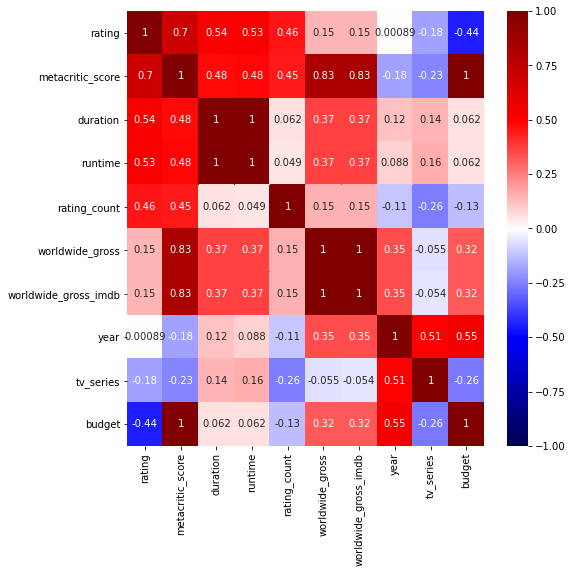

In [92]:
ix = films_df_reordered.iloc[:,:first_cast_column].corr().sort_values('rating', ascending=False).index
films_df_reordered_sorted = films_df_reordered.loc[:, ix]
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(films_df_reordered_sorted.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, ax=ax);

In [93]:
#sns.heatmap(films_df_reordered.iloc[:,:first_cast_column].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

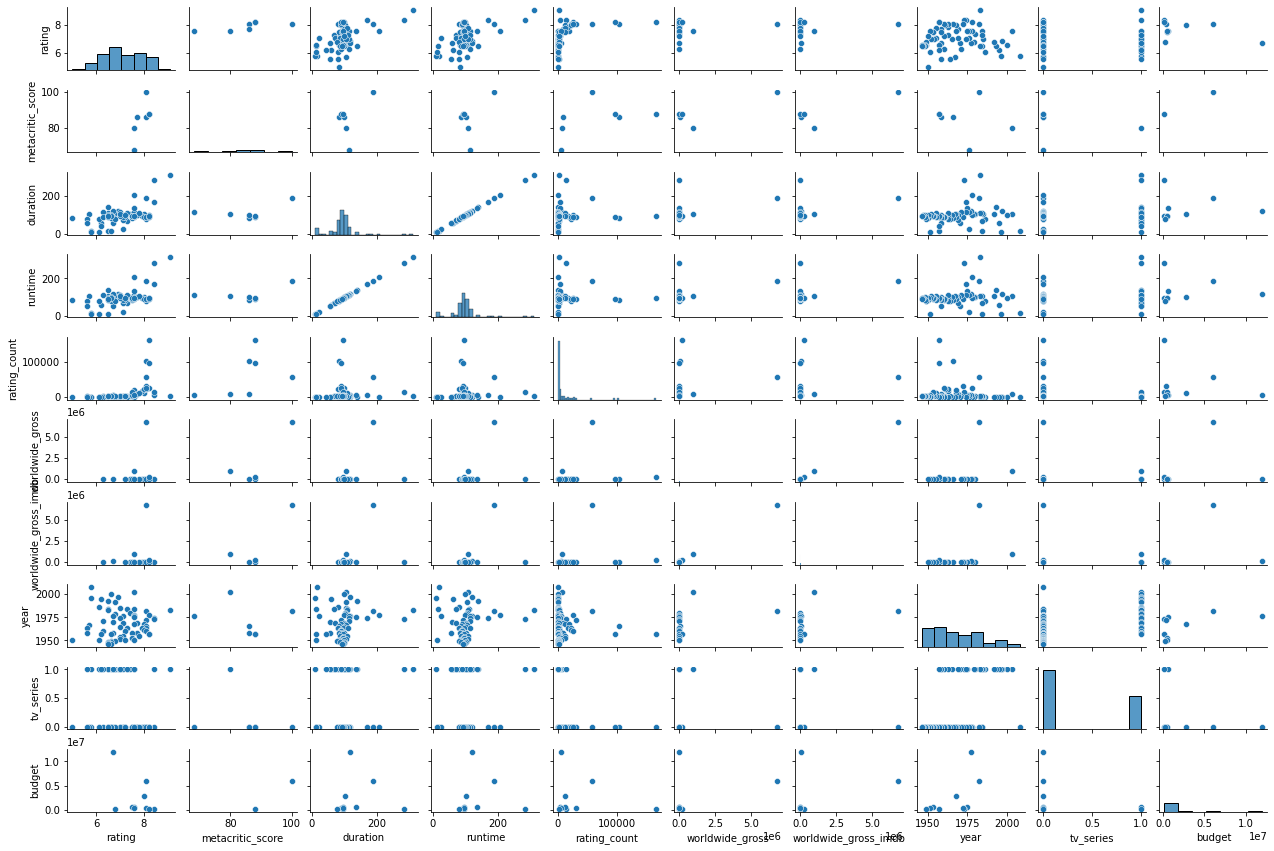

In [94]:
sns.pairplot(films_df_reordered_sorted.iloc[:,:first_cast_column], height=1.2, aspect=1.5);

#### Determine which columns have enough non-null values so they could be used

In [95]:
films_df_reordered['worldwide_gross'].value_counts(dropna=False)

NaN          50
85344.0       1
4293.0        1
6795771.0     1
5936.0        1
1848.0        1
14316.0       1
230571.0      1
6446.0        1
14338.0       1
1528.0        1
975181.0      1
10595.0       1
5135.0        1
7095.0        1
14524.0       1
10146.0       1
39238.0       1
7200.0        1
11329.0       1
13710.0       1
Name: worldwide_gross, dtype: int64

In [96]:
films_to_analyze=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['rating'].notnull()) & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]
films_to_analyze.iloc[:,5:15].head(10)


,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer
1,NaN,975181.0,975181.0,NaN,7.6,80.0,7199.0,1.0,0.0,Stefan Eriksson
2,NaN,NaN,NaN,NaN,6.6,NaN,292.0,1.0,0.0,Sofi Stridh
3,NaN,NaN,NaN,NaN,6.9,NaN,859.0,1.0,0.0,Tony Forsberg
5,NaN,NaN,NaN,NaN,6.2,NaN,145.0,1.0,0.0,Per Norén
6,NaN,NaN,NaN,NaN,6.5,NaN,40.0,1.0,0.0,Wulf Meseke
8,NaN,NaN,NaN,NaN,6.1,NaN,186.0,1.0,0.0,Per Norén
9,NaN,NaN,NaN,NaN,7.0,NaN,27.0,1.0,0.0,Klaus Günther
11,NaN,NaN,NaN,NaN,7.6,NaN,837.0,0.0,1.0,Arne Carlsson
12,NaN,NaN,NaN,NaN,7.3,NaN,2225.0,1.0,0.0,Sven Nykvist
14,NaN,NaN,NaN,NaN,9.1,NaN,2842.0,1.0,0.0,Sven Nykvist


In [97]:
len(dict_of_all_actors)

379

In [98]:
films_to_analyze.shape

(54, 395)

In [99]:
len(cast_column_names)

380

In [100]:
dict_of_all_actors

{'Bibi Andersson': 1,
 'Harriet Andersson': 1,
 'Ingmar Bergman': 1,
 'Gunnar Björnstrand': 1,
 'Marie Nyreröd': 1,
 'Max von Sydow': 1,
 'Liv Ullmann': 1,
 'Erland Josephson': 1,
 'Börje Ahlstedt': 1,
 'Julia Dufvenius': 1,
 'Gunnel Fred': 1,
 'Anita Björk': 1,
 'Elin Klinga': 1,
 'Lennart Hjulström': 1,
 'Carl Magnus Dellow': 1,
 "Henry 'Nypan' Nyberg": 1,
 'Marie Richardson': 1,
 'Pernilla August': 1,
 'Agneta Ekmanner': 1,
 'Lena Endre': 1,
 'Gerthi Kulle': 1,
 'Johan Lindell': 1,
 'Peter Stormare': 1,
 'Folke Asplund': 1,
 'Anna Björk': 1,
 'Inga Landgré': 1,
 'Alf Nilsson': 1,
 'Björn Granath': 1,
 'Benny Haag': 1,
 'Johan Rabaeus': 1,
 'Ingvar Kjellson': 1,
 'Anna von Rosen': 1,
 'Sylvia Lindenstrand': 1,
 'Laila Andersson-Palme': 1,
 'Sten Wahlund': 1,
 'Peter Mattei': 1,
 'Anita Soldh': 1,
 'Berit Lindholm': 1,
 'Paula Hoffman': 1,
 'Camilla Staern': 1,
 'Ellen Andreassen Jensen': 1,
 'Anne-Marie Mühle': 1,
 'Kristina Hammarström': 1,
 'Eva Österberg': 1,
 'Carina Morling': 1,

In [101]:
first_actor_column = (len(films_to_analyze.columns) - len(dict_of_all_actors))
first_actor_column

16

In [164]:
actor_columns = films_to_analyze.iloc[:, first_actor_column:-1].columns
actor_columns

Index(['Bibi Andersson', 'Max von Sydow', 'Erland Josephson', 'Liv Ullmann',
       'Harriet Andersson', 'Ingrid Thulin', 'Birger Malmsten', 'Åke Fridell',
       'Gunnel Lindblom', 'Allan Edwall',
       ...
       'Göran Stangertz', 'Jan-Erik Lindqvist', 'Gösta Ekman',
       'Lisbeth Zachrisson', 'Lena Wennergren', 'Nina Harte', 'Klaus Hoffmann',
       'Edith Heerdegen', 'Georg Hartmann', 'Signe Wirff'],
      dtype='object', length=378)

In [165]:
films_to_analyze[actor_columns].sum()

Bibi Andersson       11.0
Max von Sydow        11.0
Erland Josephson     13.0
Liv Ullmann          11.0
Harriet Andersson    10.0
                     ... 
Nina Harte            0.0
Klaus Hoffmann        1.0
Edith Heerdegen       1.0
Georg Hartmann        1.0
Signe Wirff           1.0
Length: 378, dtype: float64

In [166]:
actors_num_of_appearances = films_to_analyze[actor_columns].sum()
actors_num_of_appearances

Bibi Andersson       11.0
Max von Sydow        11.0
Erland Josephson     13.0
Liv Ullmann          11.0
Harriet Andersson    10.0
                     ... 
Nina Harte            0.0
Klaus Hoffmann        1.0
Edith Heerdegen       1.0
Georg Hartmann        1.0
Signe Wirff           1.0
Length: 378, dtype: float64

In [167]:
appearances_threshold = 3

In [168]:
actors_num_of_appearances

Bibi Andersson       11.0
Max von Sydow        11.0
Erland Josephson     13.0
Liv Ullmann          11.0
Harriet Andersson    10.0
                     ... 
Nina Harte            0.0
Klaus Hoffmann        1.0
Edith Heerdegen       1.0
Georg Hartmann        1.0
Signe Wirff           1.0
Length: 378, dtype: float64

In [169]:
#actors_num_of_appearances[200:]

In [170]:
#actors_num_of_appearances.where(actors_num_of_appearances >= appearances_threshold)

In [171]:
actors_num_of_appearances >= appearances_threshold

Bibi Andersson        True
Max von Sydow         True
Erland Josephson      True
Liv Ullmann           True
Harriet Andersson     True
                     ...  
Nina Harte           False
Klaus Hoffmann       False
Edith Heerdegen      False
Georg Hartmann       False
Signe Wirff          False
Length: 378, dtype: bool

In [172]:

prevalent_actors_mask = (actors_num_of_appearances >= appearances_threshold)
prevalent_actors_mask

Bibi Andersson        True
Max von Sydow         True
Erland Josephson      True
Liv Ullmann           True
Harriet Andersson     True
                     ...  
Nina Harte           False
Klaus Hoffmann       False
Edith Heerdegen      False
Georg Hartmann       False
Signe Wirff          False
Length: 378, dtype: bool

In [173]:
prevalent_actor_columns = actor_columns[prevalent_actors_mask]
prevalent_actor_columns 

Index(['Bibi Andersson', 'Max von Sydow', 'Erland Josephson', 'Liv Ullmann',
       'Harriet Andersson', 'Ingrid Thulin', 'Birger Malmsten', 'Åke Fridell',
       'Gunnel Lindblom', 'Allan Edwall', 'Naima Wifstrand', 'Ulf Johansson',
       'Eva Dahlbeck', 'Ingmar Bergman', 'Axel Düberg', 'Gertrud Fridh',
       'Inga Landgré', 'Jarl Kulle', 'Gösta Prüzelius', 'Kristina Adolphson',
       'Stig Olin', 'Anita Björk', 'Bengt Eklund', 'Birgitta Valberg',
       'Yngve Nordwall', 'Anders Ek', 'Sif Ruud', 'Börje Ahlstedt',
       'Sigge Fürst', 'Erik Hell', 'Lars Ekborg', 'Bertil Guve', 'Ewa Fröling',
       'Maj-Britt Nilsson', 'Georg Funkquist', 'Hasse Ekman', 'Åke Grönberg',
       'Barbro Hiort af Ornäs', 'Sven Lindberg', 'Gudrun Brost',
       'Gunnar Sjöberg', 'Björn Bjelfvenstam', 'Douglas Håge'],
      dtype='object')

In [174]:
actor_columns

Index(['Bibi Andersson', 'Max von Sydow', 'Erland Josephson', 'Liv Ullmann',
       'Harriet Andersson', 'Ingrid Thulin', 'Birger Malmsten', 'Åke Fridell',
       'Gunnel Lindblom', 'Allan Edwall',
       ...
       'Göran Stangertz', 'Jan-Erik Lindqvist', 'Gösta Ekman',
       'Lisbeth Zachrisson', 'Lena Wennergren', 'Nina Harte', 'Klaus Hoffmann',
       'Edith Heerdegen', 'Georg Hartmann', 'Signe Wirff'],
      dtype='object', length=378)

#### These next few cells are legacy  -----------------------------------------

#### End of legacy code  -----------------------------------------

In [175]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [176]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Bibi Andersson',
 'Max von Sydow',
 'Erland Josephson',
 'Liv Ullmann',
 'Harriet Andersson',
 'Ingrid Thulin',
 'Birger Malmsten',
 'Åke Fridell',
 'Gunnel Lindblom',
 'Allan Edwall',
 'Naima Wifstrand',
 'Ulf Johansson',
 'Eva Dahlbeck',
 'Ingmar Bergman',
 'Axel Düberg',
 'Gertrud Fridh',
 'Inga Landgré',
 'Jarl Kulle',
 'Gösta Prüzelius',
 'Kristina Adolphson',
 'Stig Olin',
 'Anita Björk',
 'Bengt Eklund',
 'Birgitta Valberg',
 'Yngve Nordwall',
 'Anders Ek',
 'Sif Ruud',
 'Börje Ahlstedt',
 'Sigge Fürst',
 'Erik Hell',
 'Lars Ekborg',
 'Bertil Guve',
 'Ewa Fröling',
 'Maj-Britt Nilsson',
 'Georg Funkquist',
 'Hasse Ekman',
 'Åke Grönberg',
 'Barbro Hiort af Ornäs',
 'Sven Lindberg',
 'Gudrun Brost',
 'Gunnar Sjöberg',
 'Björn Bjelfvenstam',
 'Douglas Håge']

## Dataset partitioned for analysis

In [177]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [178]:
x_label = 'year'
y_label = 'rating'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

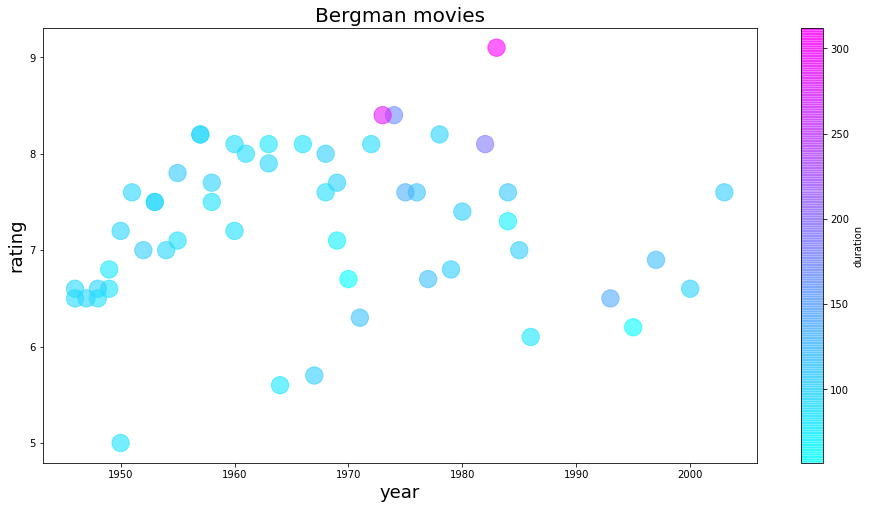

In [179]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'duration'
cm=films_and_features_to_analyze_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

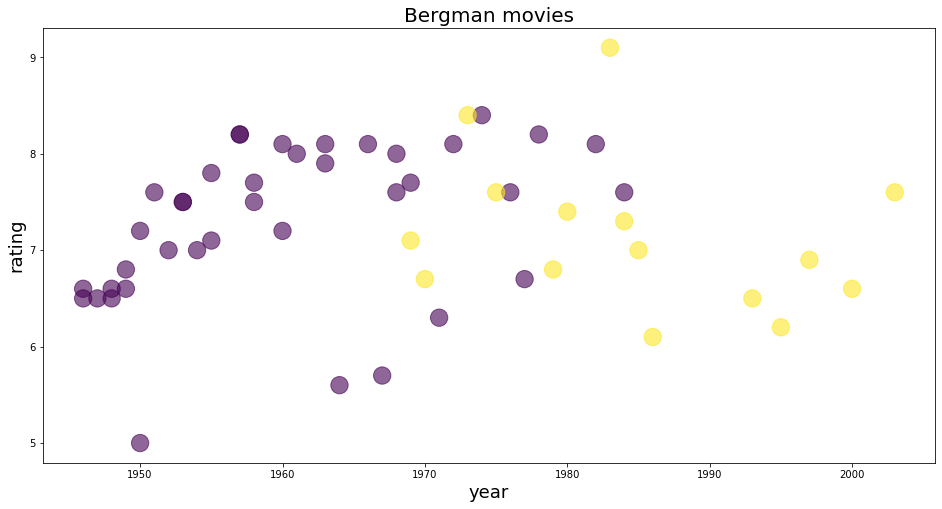

In [180]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [181]:
x_label = 'year'
y_label = 'duration'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

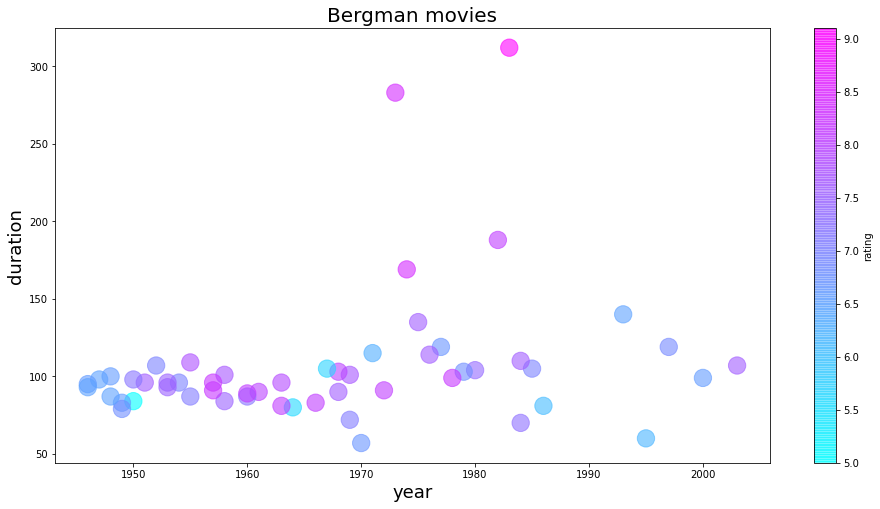

In [182]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'rating'
cm=films_and_features_to_analyze_df[color_dimension ].tolist()
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

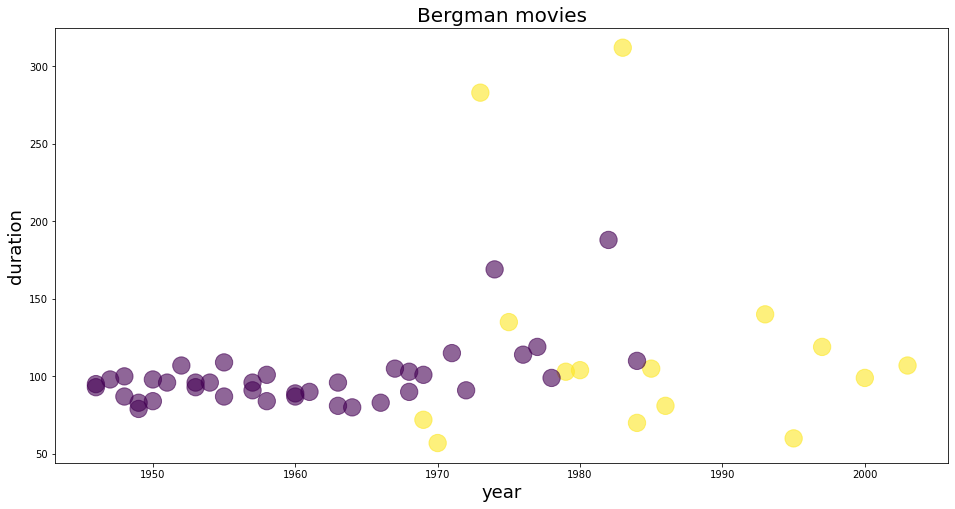

In [183]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


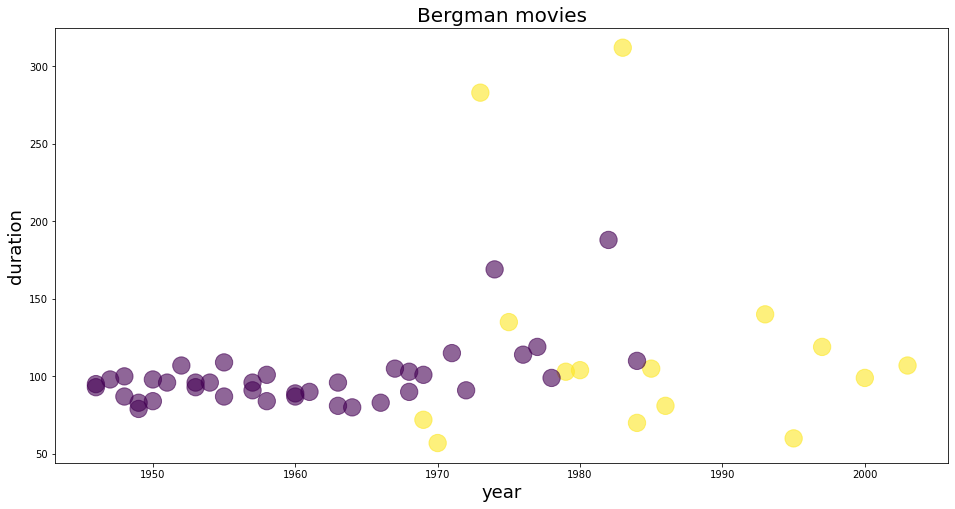

In [184]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


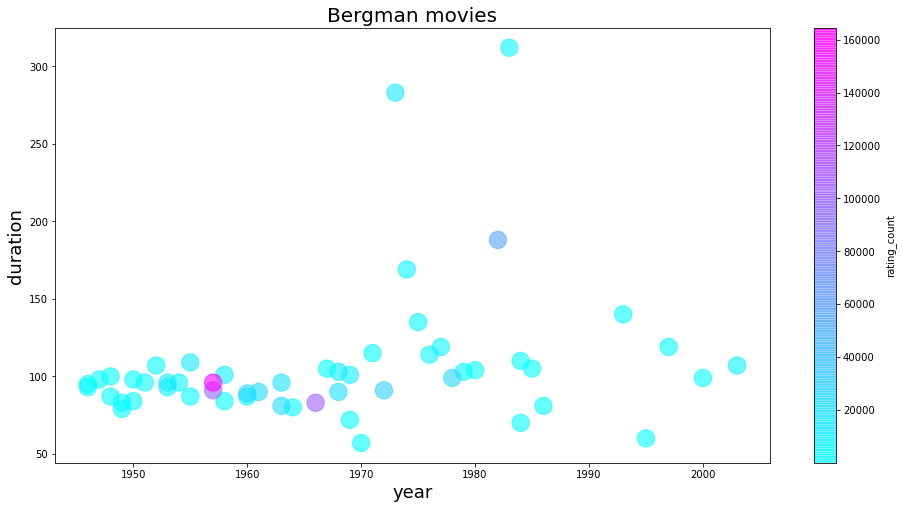

In [185]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'rating_count'
cmap=plt.get_cmap("cool")
cm=films_and_features_to_analyze_df[color_dimension ].tolist()
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )
#plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [186]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

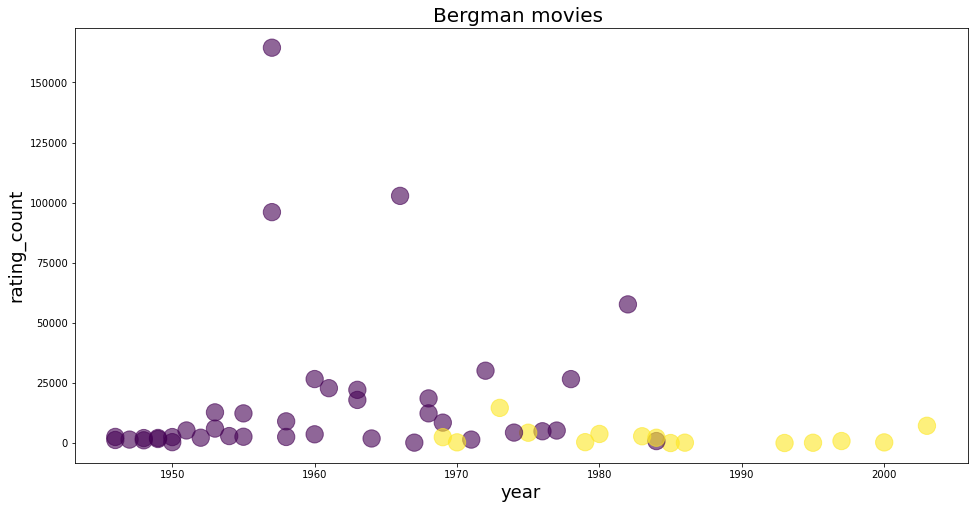

In [187]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


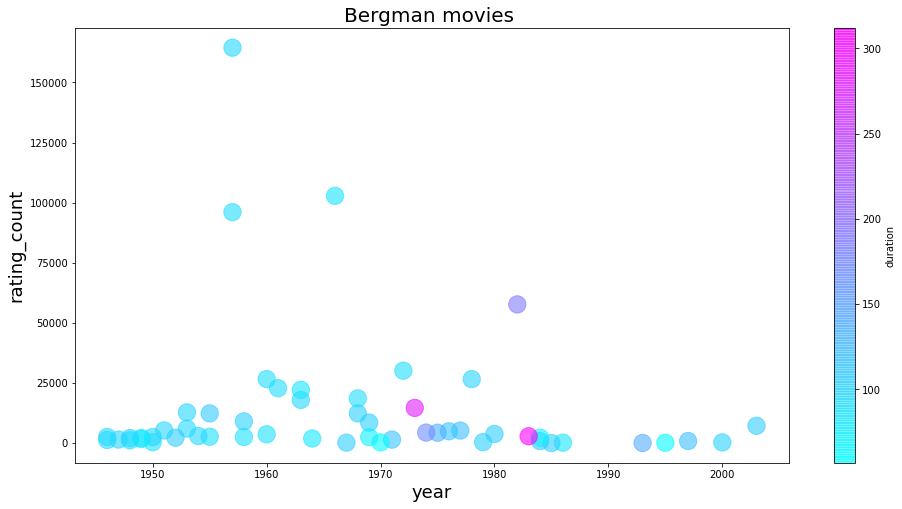

In [188]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
color_dimension = 'duration'

cm=films_and_features_to_analyze_df[color_dimension ].tolist()
cmap=plt.get_cmap("cool")
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

In [189]:
#films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1]

In [190]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][x_label]
y_ = films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][y_label]

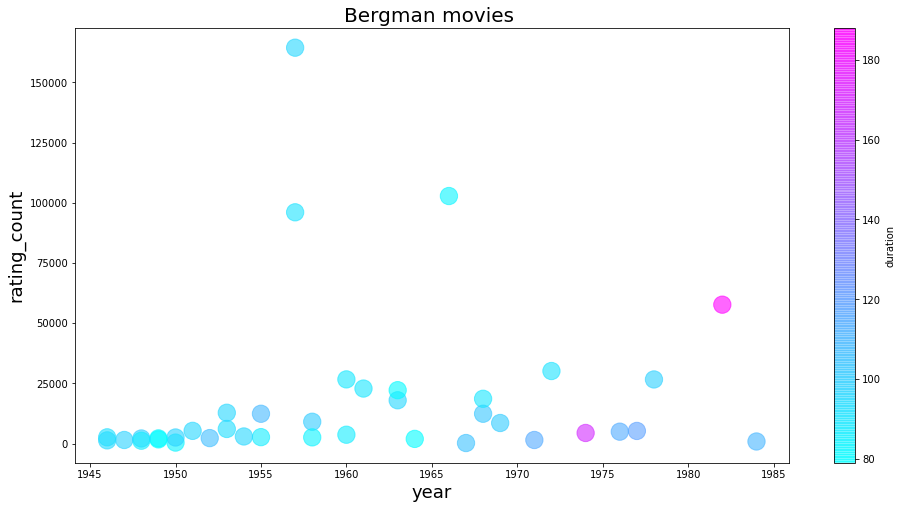

In [191]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
color_dimension = 'duration'

cm=films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][color_dimension ].tolist()
cmap=plt.get_cmap("cool")
#category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

In [192]:
print( min(x_), max(x_))

1946.0 1984.0


In [193]:
from scipy import signal
signal.unit_impulse(1960) # come back to this to attempt to model "dirac impulse response" 
# for rating count based on year

array([1., 0., 0., ..., 0., 0., 0.])

In [194]:
films_and_features_to_analyze_df[films_and_features_to_analyze_df['duration'] <65]

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Bibi Andersson,Max von Sydow,...,Maj-Britt Nilsson,Georg Funkquist,Hasse Ekman,Åke Grönberg,Barbro Hiort af Ornäs,Sven Lindberg,Gudrun Brost,Gunnar Sjöberg,Björn Bjelfvenstam,Douglas Håge
5,Sista skriket,1995.0,60.0,Per Norén,0.0,1.0,6.2,145.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,Fårö Document,1970.0,57.0,Sven Nykvist,1.0,1.0,6.7,310.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Breakdown by **cinematographers** Jack E. Cox, Robert Burks, and Bernard Knowles 

In [195]:
cinematographer = 'Jack E. Cox'

In [196]:
ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


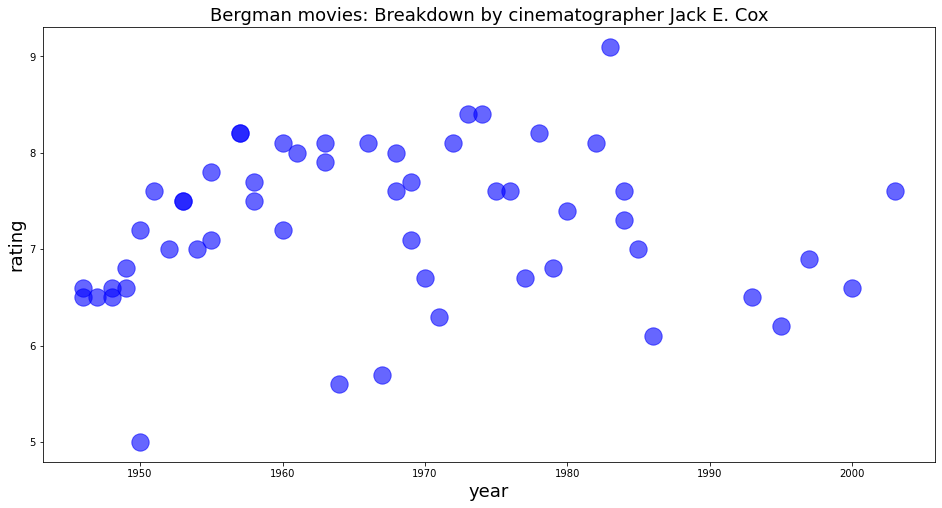

In [197]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [198]:
cinematographer = 'Robert Burks'

In [199]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


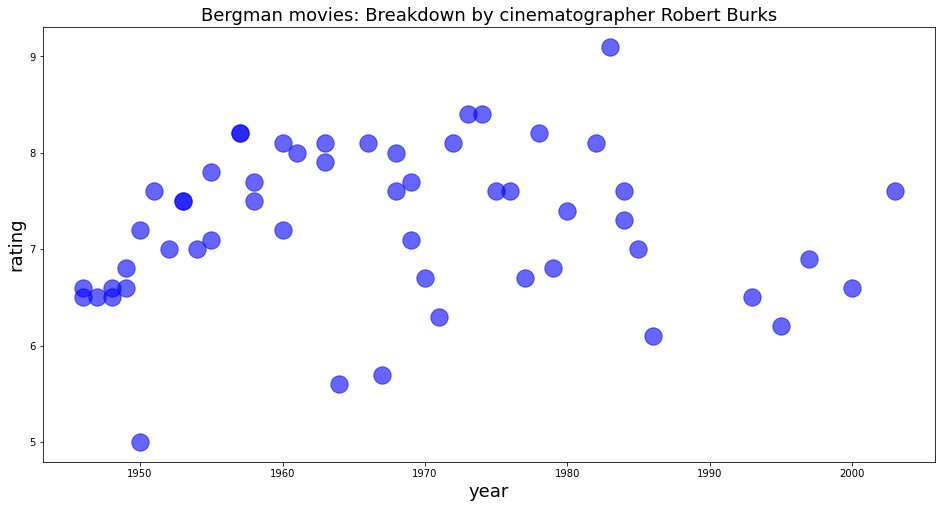

In [200]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [201]:
cinematographer = 'Bernard Knowles'

In [202]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


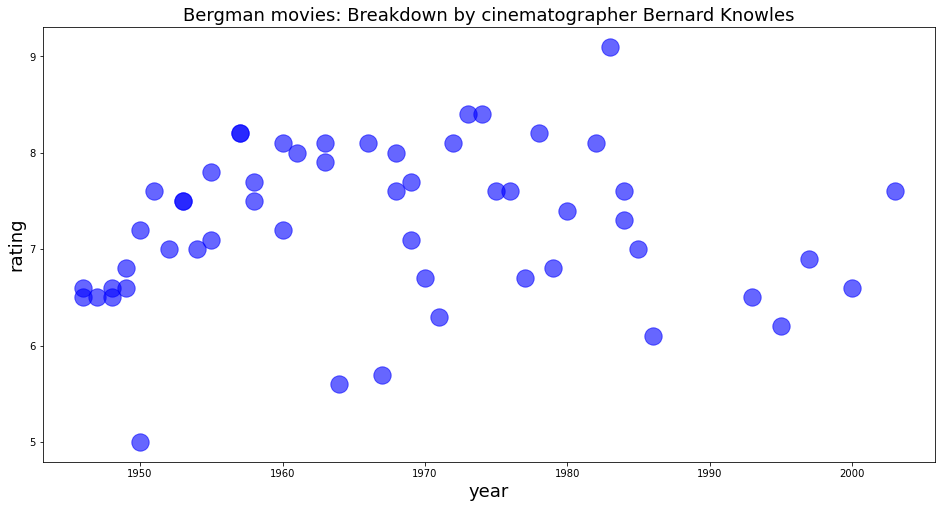

In [203]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: ' + 'Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

#### Recode misc. cinematographers to `OTHER` to ameliorate issue of not dropping a column and also to increase the chance it will occur in the test set as well

In [204]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [205]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Train Test Split

In [206]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Bibi Andersson',
       'Max von Sydow', 'Erland Josephson', 'Liv Ullmann', 'Harriet Andersson',
       'Ingrid Thulin', 'Birger Malmsten', 'Åke Fridell', 'Gunnel Lindblom',
       'Allan Edwall', 'Naima Wifstrand', 'Ulf Johansson', 'Eva Dahlbeck',
       'Ingmar Bergman', 'Axel Düberg', 'Gertrud Fridh', 'Inga Landgré',
       'Jarl Kulle', 'Gösta Prüzelius', 'Kristina Adolphson', 'Stig Olin',
       'Anita Björk', 'Bengt Eklund', 'Birgitta Valberg', 'Yngve Nordwall',
       'Anders Ek', 'Sif Ruud', 'Börje Ahlstedt', 'Sigge Fürst', 'Erik Hell',
       'Lars Ekborg', 'Bertil Guve', 'Ewa Fröling', 'Maj-Britt Nilsson',
       'Georg Funkquist', 'Hasse Ekman', 'Åke Grönberg',
       'Barbro Hiort af Ornäs', 'Sven Lindberg', 'Gudrun Brost',
       'Gunnar Sjöberg', 'Björn Bjelfvenstam', 'Douglas Håge'],
      dtype='object')

In [207]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [208]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

#### Categorical Variable Preprocessing

In [210]:
cat_ohe_vars = ['cinematographer']
X_train_cat_ohe = X_train[cat_ohe_vars]
#X_train_cat_ohe 

#### OneHotEncoding

In [211]:
#ohe = OneHotEncoder(sparse=False, drop='first')
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_cat_ohe)
cats_ohe = ohe.transform(X_train_cat_ohe)


In [212]:
columns=ohe.get_feature_names(cat_ohe_vars)

columns

array(['cinematographer_Arne Carlsson', 'cinematographer_Gunnar Fischer',
       'cinematographer_Göran Strindberg',
       'cinematographer_Hilding Bladh', 'cinematographer_OTHER',
       'cinematographer_Sven Nykvist'], dtype=object)

In [213]:
X_train_cat_ohe_df = pd.DataFrame(cats_ohe, columns=columns, index=X_train_cat_ohe.index)
X_train_cat_ohe_df.head()

,cinematographer_Arne Carlsson,cinematographer_Gunnar Fischer,cinematographer_Göran Strindberg,cinematographer_Hilding Bladh,cinematographer_OTHER,cinematographer_Sven Nykvist
54,0.0,0.0,0.0,1.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,0.0,1.0,0.0
12,0.0,0.0,0.0,0.0,0.0,1.0
24,0.0,0.0,0.0,0.0,0.0,1.0


#### Repeating transformations on testing set

In [214]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cats_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cats_ohe_test, columns=cat_ohe_columns)

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [215]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head(70)



,year,duration,rating_count
54,1955.0,87.0,2644.0
22,1976.0,114.0,4919.0
9,1985.0,105.0,27.0
12,1984.0,70.0,2225.0
24,1974.0,169.0,4376.0
29,1970.0,57.0,310.0
61,1950.0,84.0,384.0
17,1979.0,103.0,391.0
28,1971.0,115.0,1461.0
53,1955.0,109.0,12356.0


####  scale the continuous variables in the train set

In [216]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
54,-0.747581,-0.481124,-0.376408
22,0.611657,0.302607,-0.305904
9,1.194187,0.041364,-0.457511
12,1.129462,-0.974584,-0.389393
24,0.482206,1.899096,-0.322732


#### select and scale the continuous variables in the test set

In [217]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
5,1995.0,60.0,145.0
47,1958.0,84.0,2550.0
34,1967.0,105.0,196.0
57,1953.0,96.0,12778.0
19,1978.0,99.0,26609.0


In [218]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
5,1.841443,-1.264854,-0.453854
47,-0.553404,-0.568205,-0.379321
34,0.029127,0.041364,-0.452274
57,-0.877032,-0.219880,-0.062347
19,0.741108,-0.132799,0.366288


### Combine the continuous, categorical, and ohe cat features for our testing set


In [219]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_cat_df = X_train[cat_columns]


In [220]:
X_train_combined = pd.concat([X_train_scaled_df, X_train_cat_ohe_df, X_train_cat_df, ], axis='columns')

X_train_combined.head(10)

,year,duration,rating_count,cinematographer_Arne Carlsson,cinematographer_Gunnar Fischer,cinematographer_Göran Strindberg,cinematographer_Hilding Bladh,cinematographer_OTHER,cinematographer_Sven Nykvist,documentary,...,Maj-Britt Nilsson,Georg Funkquist,Hasse Ekman,Åke Grönberg,Barbro Hiort af Ornäs,Sven Lindberg,Gudrun Brost,Gunnar Sjöberg,Björn Bjelfvenstam,Douglas Håge
54,-0.747581,-0.481124,-0.376408,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
22,0.611657,0.302607,-0.305904,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,1.194187,0.041364,-0.457511,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,1.129462,-0.974584,-0.389393,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.482206,1.899096,-0.322732,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,0.223303,-1.351936,-0.448741,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,-1.071209,-0.568205,-0.446447,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.805834,-0.016691,-0.446230,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.288029,0.331634,-0.413070,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,-0.747581,0.157472,-0.075425,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [221]:
X_train.shape

(40, 49)

### Combine the continuous and categorical features for our testing set


In [222]:
X_test_cat_df = X_test[cat_columns]

In [223]:
X_test_scaled_df.shape[0] == X_test_cat_df.shape[0] == X_test_cat_ohe_df.shape[0]


True

In [224]:
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
#X_test_combined = pd.concat([X_test_scaled_df, X_test_cat_ohe_df, X_test_cat_df ], axis=1)

X_test_combined

,year,duration,rating_count,cinematographer_Arne Carlsson,cinematographer_Gunnar Fischer,cinematographer_Göran Strindberg,cinematographer_Hilding Bladh,cinematographer_OTHER,cinematographer_Sven Nykvist,documentary,...,Maj-Britt Nilsson,Georg Funkquist,Hasse Ekman,Åke Grönberg,Barbro Hiort af Ornäs,Sven Lindberg,Gudrun Brost,Gunnar Sjöberg,Björn Bjelfvenstam,Douglas Håge
0,1.841443,-1.264854,-0.453854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.553404,-0.568205,-0.379321,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.029127,0.041364,-0.452274,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.877032,-0.219880,-0.062347,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.741108,-0.132799,0.366288,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.093852,-0.016691,-0.075301,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,1.000010,2.450610,1.329236,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-1.200660,-0.481124,-0.422553,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8,1.064736,6.049966,-0.370272,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-1.135934,-0.597232,-0.392182,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now make predictions by instantiating the Linear Regression Model 

In [225]:
lr = LinearRegression()

lr.fit(X_train_combined, y_train)

LinearRegression()

In [226]:
lr.coef_

array([-0.37961784, -0.29874386,  0.18847677,  0.86052573, -0.41038654,
       -0.38846676, -0.07283391, -0.11762804,  0.12878952, -1.33287499,
        0.91843338,  0.01441727, -0.30805483,  0.73002015,  0.49960602,
        0.57190671, -0.38473209,  0.14613625,  0.27422445,  1.08727478,
        0.49961298,  0.60226736, -0.3698753 , -0.75820066, -0.01217418,
       -0.48199733,  0.07708695, -0.12171479, -0.3249606 ,  0.71282773,
       -0.31167203, -0.53702252, -0.08501295,  0.28129003,  0.29722841,
       -1.29596036, -0.26133343,  0.74581764, -0.21189707,  0.14032136,
       -0.1817189 , -0.10861239, -0.63262326,  0.66975169,  0.86691771,
        0.39115309,  0.26035582,  0.10773877,  0.        , -0.33968536,
       -0.23047666,  0.7560131 ,  0.55985142, -0.62924369])

In [227]:
y_pred = lr.predict(X_test_combined)

y_pred

array([7.26283194, 6.86957334, 6.86641114, 8.42601072, 7.93690422,
       8.08841552, 5.54988491, 6.94329771, 5.01723983, 8.16650267,
       7.56234023, 6.93310506, 7.54283345, 7.44482587])

In [228]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 1.60
r2: -1.41


In [229]:
print(r2)

-1.4061347920498921


In [230]:
score = lr.score(X_test_combined, y_test) 
score

-1.4061347920498921

# Focus on building up from fewer features

### Train Test Split

In [231]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Bibi Andersson',
       'Max von Sydow', 'Erland Josephson', 'Liv Ullmann', 'Harriet Andersson',
       'Ingrid Thulin', 'Birger Malmsten', 'Åke Fridell', 'Gunnel Lindblom',
       'Allan Edwall', 'Naima Wifstrand', 'Ulf Johansson', 'Eva Dahlbeck',
       'Ingmar Bergman', 'Axel Düberg', 'Gertrud Fridh', 'Inga Landgré',
       'Jarl Kulle', 'Gösta Prüzelius', 'Kristina Adolphson', 'Stig Olin',
       'Anita Björk', 'Bengt Eklund', 'Birgitta Valberg', 'Yngve Nordwall',
       'Anders Ek', 'Sif Ruud', 'Börje Ahlstedt', 'Sigge Fürst', 'Erik Hell',
       'Lars Ekborg', 'Bertil Guve', 'Ewa Fröling', 'Maj-Britt Nilsson',
       'Georg Funkquist', 'Hasse Ekman', 'Åke Grönberg',
       'Barbro Hiort af Ornäs', 'Sven Lindberg', 'Gudrun Brost',
       'Gunnar Sjöberg', 'Björn Bjelfvenstam', 'Douglas Håge'],
      dtype='object')

In [232]:
selected_cols = ['year', 'duration', 'rating_count']

In [233]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

## For now, ignore these categorical variables

#### Categorical Variable Preprocessing

#### OneHotEncoding

#### Repeating transformations on testing set

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [235]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head()



,year,duration,rating_count
61,1950.0,84.0,384.0
33,1968.0,90.0,18584.0
57,1953.0,96.0,12778.0
41,1961.0,90.0,22833.0
15,1982.0,188.0,57681.0


####  scale the continuous variables in the train set

In [236]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
61,-1.239127,-0.541913,-0.512249
33,-0.030223,-0.395450,0.283037
57,-1.037643,-0.248987,0.029332
41,-0.500352,-0.395450,0.468705
15,0.910037,1.996780,1.991459


#### select and scale the continuous variables in the test set

In [237]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
66,1948.0,87.0,1155.0
25,1973.0,283.0,14645.0
58,1952.0,107.0,2246.0
43,1960.0,89.0,26633.0
56,1953.0,93.0,6039.0


In [238]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
66,-1.373450,-0.468682,-0.478559
25,0.305584,4.315778,0.110914
58,-1.104805,0.019528,-0.430885
43,-0.567514,-0.419861,0.634754
56,-1.037643,-0.322219,-0.265143


### Combine the continuous, categorical, and ohe cat features for our testing set


## for now, ignore these categorical variables

## 'combine' will really just be the continuous variables

In [239]:
X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

X_train_combined.head()

,year,duration,rating_count
0,-1.239127,-0.541913,-0.512249
1,-0.030223,-0.395450,0.283037
2,-1.037643,-0.248987,0.029332
3,-0.500352,-0.395450,0.468705
4,0.910037,1.996780,1.991459


In [240]:
X_train_combined.shape

(40, 3)

### Combine the continuous and categorical features for our testing set


In [241]:
#X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

X_test_combined

,year,duration,rating_count
0,-1.373450,-0.468682,-0.478559
1,0.305584,4.315778,0.110914
2,-1.104805,0.019528,-0.430885
3,-0.567514,-0.419861,0.634754
4,-1.037643,-0.322219,-0.265143
5,1.178682,-0.615145,-0.520901
6,-1.440612,-0.200166,-0.465100
7,-0.768998,-0.248987,6.656509
8,-0.903321,-0.468682,-0.413494
9,2.118941,-0.175756,-0.516269


### Now make predictions by instantiating the Linear Regression Model 

In [242]:
#X_train_combined

In [243]:
lr = LinearRegression()

lr.fit(X_train_combined,y_train)

LinearRegression()

In [244]:
lr.coef_

array([0.04819399, 0.36173782, 0.39083174])

In [245]:

y_pred = lr.predict(X_test_combined)

y_pred

array([6.81473203, 8.85675619, 7.02291552, 7.30635169, 6.96730698,
       6.86819949, 6.91388759, 9.71194602, 6.86281887, 7.07426831,
       7.22970313, 7.22294669, 6.79941611, 6.89621755])

In [246]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.64
r2: 0.15


In [247]:
score = lr.score(X_test_combined, y_test) 
score

0.14780736175222675

## Try to fit with just the year

In [248]:
lr = LinearRegression()

In [249]:
X_train_year_only = X_train_combined.iloc[:, :1]

In [250]:
X_test_year_only = X_test_combined.iloc[:, :1]

In [251]:
#X_train_year_only 

In [252]:
lr.fit(X_train_year_only, y_train)

LinearRegression()

In [253]:
lr.coef_

array([0.14930814])

In [254]:
y_pred = lr.predict(X_test_year_only)

y_pred

array([7.03243271, 7.28312622, 7.07254367, 7.15276559, 7.08257141,
       7.41348685, 7.02240497, 7.12268237, 7.10262689, 7.55387521,
       7.18284881, 7.10262689, 7.39343136, 7.15276559])

In [255]:
y_test

66    6.5
25    8.4
58    7.0
43    8.1
56    7.5
8     6.1
67    6.5
52    8.2
54    7.1
2     6.6
38    7.9
53    7.8
12    7.3
42    7.2
Name: rating, dtype: float64

In [256]:
#y_test

In [257]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [258]:
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.74
r2: -0.15


## Try to fit with just the `year` and `duration`


In [259]:
lr = LinearRegression()

X_train_year_dur_only = X_train_combined.iloc[:, :2]

X_test_year_dur_only = X_test_combined.iloc[:, :2]

#X_train_year_only 

lr.fit(X_train_year_dur_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_dur_only)

y_pred

y_test

#y_test

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.63
r2: 0.16


## Try to fit with just the `year` and `rating_count`

In [260]:
X_train_combined[['year', 'rating_count']]

,year,rating_count
0,-1.239127,-0.512249
1,-0.030223,0.283037
2,-1.037643,0.029332
3,-0.500352,0.468705
4,0.910037,1.991459
5,0.372746,-0.337811
6,-1.507773,-0.416815
7,0.775714,-0.362849
8,1.783135,-0.522693
9,-1.306289,-0.435736


In [261]:
lr = LinearRegression()

X_train_year_rc_only = X_train_combined[['year', 'rating_count']]

X_test_year_rc_only = X_test_combined[['year', 'rating_count']]



lr.fit(X_train_year_rc_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_rc_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.72
r2: -0.10


## Feature engineer: include log(`year`) and and log(`rating_count`)

####  scale the continuous variables in the train set

In [262]:
X_train_cont_w_log = copy.deepcopy(X_train_cont) 
X_test_cont_w_log = copy.deepcopy(X_test_cont) 

X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)

In [263]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont_w_log)
X_train_scaled = ss.transform(X_train_cont_w_log)

cont_columns = X_train_cont_w_log.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
61,-1.239127,-0.541913,-0.512249,-1.242626,-1.115216
33,-0.030223,-0.395450,0.283037,-0.026480,0.962810
57,-1.037643,-0.248987,0.029332,-1.039158,0.762167
41,-0.500352,-0.395450,0.468705,-0.498099,1.073105
15,0.910037,1.996780,1.991459,0.911745,1.569507


In [264]:
X_test_scaled = ss.transform(X_test_cont_w_log)

cont_columns = X_test_cont_w_log.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
66,-1.373450,-0.468682,-0.478559,-1.378446,-0.525346
25,0.305584,4.315778,0.110914,0.309364,0.835216
58,-1.104805,0.019528,-0.430885,-1.106946,-0.169109
43,-0.567514,-0.419861,0.634754,-0.565611,1.155566
56,-1.037643,-0.322219,-0.265143,-1.039158,0.360701


In [265]:
lr = LinearRegression()

lr.fit(X_train_scaled_df, y_train)

lr.coef_

y_pred = lr.predict(X_test_scaled_df)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.27
r2: 0.84


In [266]:
lr.coef_

array([-1.70819363e+01,  2.75386466e-01, -9.33919621e-03,  1.72692489e+01,
        5.70126334e-01])

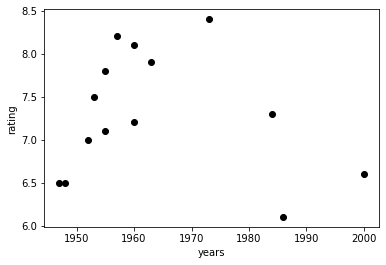

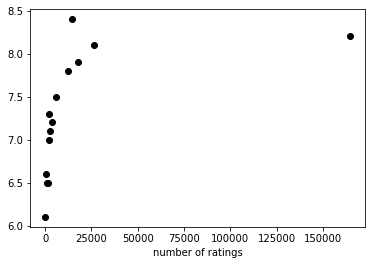

In [267]:
plt.ylabel("rating")
plt.scatter(X_test_cont_w_log['year'], y_test,  color='black')
plt.xlabel('years')
plt.show()
#plt.plot(X_test_cont_w_log['year'], y_pred, color='blue', linewidth=3)
plt.scatter(X_test_cont_w_log['rating_count'], y_test,  color='black')
plt.xlabel('number of ratings')
plt.show()

### Fit to only  `log_rating_count` and maybe `log_year`


In [268]:
lr = LinearRegression()

X_train_logs_only = X_train_scaled_df[['year','log_rating_count']]

X_test_logs_only = X_test_scaled_df[['year','log_rating_count']]



lr.fit(X_train_logs_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_logs_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.31
r2: 0.80


## Repartition data set to analyze `worldwide_gross`

In [ ]:
films_df_reordered

In [ ]:
films_to_analyze_profits=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['worldwide_gross'].notnull()) & (films_df_reordered['worldwide_gross']!='') & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]
#films_to_analyze_profits=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['rating'].notnull()) & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]

films_to_analyze_profits.iloc[:,8:15]


In [ ]:
new_analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', 'worldwide_gross', *selected_actor_columns]

In [ ]:
films_and_features_to_analyze_profits = films_to_analyze_profits[new_analysis_columns]

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'rating'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'duration'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'rating_count'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'James Stewart'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'Cary Grant'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'Grace Kelly'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

### Repartition data set to analyze `worldwide_gross` in terms of `budget` etc.

In [ ]:

films_to_analyze_profits_and_budget=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['worldwide_gross'].notnull()) & (films_df_reordered['worldwide_gross']!='') & (films_df_reordered['budget'].notnull()) & (films_df_reordered['budget']!='')& (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]

films_to_analyze_profits_and_budget.iloc[:,8:15]
films_to_analyze_profits_and_budget


In [ ]:
new_analysis_columns_budget = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', 'budget', 'worldwide_gross', *selected_actor_columns]

In [ ]:
films_and_features_to_analyze_profits_and_budget = films_to_analyze_profits_and_budget[new_analysis_columns_budget]

In [ ]:
x_label = 'year'
y_label = 'budget'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'duration'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'rating'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))